# **Big Data / Accident Data analysis**

#### **Installing libraries**

In [1]:
# !pip install selenium
# !pip install pillow
# !pip install folium
# !pip install tabulate

### **Import required libraries**

In [2]:
import sqlite3
import io
from PIL import Image
import selenium

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import folium
import matplotlib.pyplot as plt
%matplotlib inline


import scipy.stats as stats
import folium

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from folium.plugins import MarkerCluster
from IPython.display import display
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")

#### **Connection the sqlite database**

1. Creating a connection
2. Creating a cursor
3. Identifying the tables in the databases
4. veiwing the attributes

In [3]:
# Connect to the sqlite database
conn = sqlite3.connect('accident_data_v1.0.0_2023.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()
print("\n\033[1mPrint all tables\033[0m")
for name in table_names:
    print(f"Tables Name: {name[0]}")

#Print all the tables
print("\n\033[1mPrint all columns for every table\033[0m")
table_columns = {}
for table in table_names:
    table_name = table[0]
    cursor.execute(f"PRAGMA table_info({table_name})")
    col_info = cursor.fetchall()
    column_names = [col[1] for col in col_info]
    table_columns[table_name] = column_names
for table, columns in table_columns.items():
    print(f"Column names for {table} table:")
    print(columns)
    print()

#Length the tables
print("\n\033[1mPrint the length of the each columns for every table\033[0m")
for table in table_names:
    table_name = table[0]
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    print(f"Table: {table_name}, Length: {count}")


Print all tables
Tables Name: accident
Tables Name: casualty
Tables Name: vehicle
Tables Name: lsoa

Print all columns for every table
Column names for accident table:
['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'lsoa_of_accident_location']

Column names for casualt

## **1. Hours of the Day and Days of the Week for Accidents**
In this task, we will focus solely on essential attributes: the accident index, time, and day of the week. Then, we'll extract the hour feature from the time attribute.

In [4]:
#Extracting the relevent columns from the accident table
cursor.execute("""
SELECT a.accident_index, a.time, a.day_of_week
FROM Accident a
WHERE a.accident_year = 2020;
""")

accident = cursor.fetchall()

#convert the pandas DataFrame to store the results
accident_df = pd.DataFrame(
    accident, columns = ['accident_index', 'time', 'day_of_week']
)

accident_df.head(5)

accident_index   time  day_of_week
0  2020010219808  09:00            3
1  2020010220496  13:55            2
2  2020010228005  01:25            4
3  2020010228006  01:50            4
4  2020010228011  02:25            4

In [5]:
# Extract hour and day of the week from the datetime column
accident_df['hour'] = pd.to_datetime(accident_df['time'], format="%H:%M").dt.hour
accident_df.head()

accident_index   time  day_of_week  hour
0  2020010219808  09:00            3     9
1  2020010220496  13:55            2    13
2  2020010228005  01:25            4     1
3  2020010228006  01:50            4     1
4  2020010228011  02:25            4     2

#### **Defining the function for find distribution plot**

In [6]:
def distribution_plot(data, column, labels, title, xlabel, ylabel,colors=None,x_ticks=None, colormap=None, x_tick_labels=None, save_path=None):
    counts = data.groupby(column).size()
    total_accidents = counts.sum()
    percentages = (counts / total_accidents) * 100
    
    # Define colors using a colormap
    if colormap:
        colors = sns.color_palette(colormap, len(labels))
        
    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, counts.values, color=colors)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if x_ticks and x_tick_labels:
        plt.xticks(x_ticks, x_tick_labels)

    # Annotate with percentage
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = percentages.values[i]
        ax.annotate('{:.1f}%'.format(percentage), (bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


######  Accident occurrence during the hours of a day 


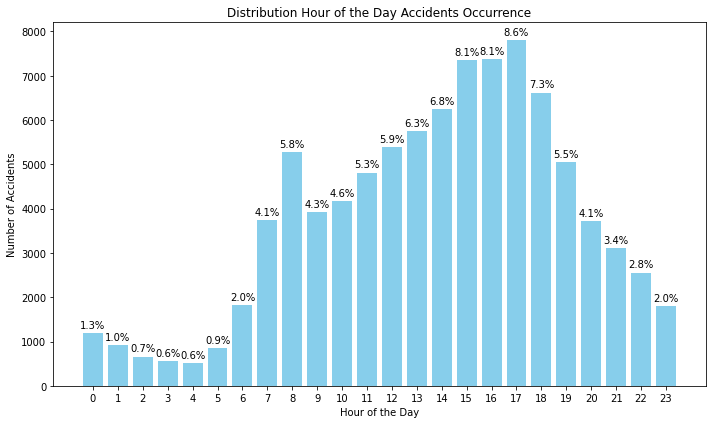

In [7]:
#Significant Hour of the Day for Accidents Occurrence
distribution_plot(accident_df, 'hour', range(24),
                  'Distribution Hour of the Day Accidents Occurrence',
                  'Hour of the Day', 'Number of Accidents',colors='skyblue',
                  x_ticks=range(24), x_tick_labels=range(24),save_path="Daily_accident.png")

**Interpretation:**
The graph shows the number of accidents that occurred at different times of the day. The x-axis shows the hour of the day, and the y-axis shows the number of accidents. The most common time for accidents to occur was between 16:00 and 17:00, with 8.6% of accidents occurring during this time. The least common time for accidents to occur was between 4:00 and 5:00, with only 0.6% of accidents occurring during this time.

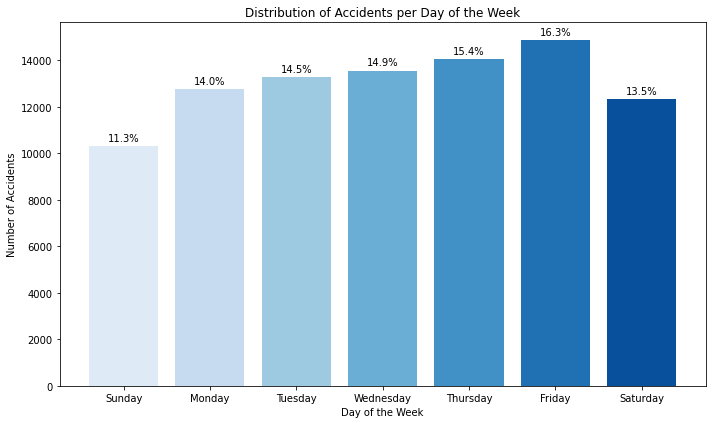

In [8]:
# Accidents per Day of the Week
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
distribution_plot(accident_df, 'day_of_week', days,
                  'Distribution of Accidents per Day of the Week',
                  'Day of the Week', 'Number of Accidents',save_path="weekly.png",
                 colormap='Blues')

**Interpretation:**
The bar plot illustrates the varying patterns of accidents throughout the week. Notably, Friday emerges as the day with the highest frequency of accidents, comprising 16.3% of the total. This trend likely stems from increased activities and anticipation of the weekend. Following closely, Thursday contributes 15.4% to the total accidents, indicating similar pre-weekend dynamics. Mid-week days, Wednesday and Tuesday, maintain notable accident counts at 14.9% and 14.5%, respectively, possibly influenced by accumulated stress and fatigue. Monday, reflecting early-week adjustments, accounts for 14.0% of accidents. Weekends see a decline in accidents, with Saturday at 13.5%, associated with leisure activities, and Sunday recording the lowest percentage at 11.3%, reflecting reduced work-related travel. Understanding these patterns informs targeted safety measures and traffic management interventions, focusing on weekdays with higher accident risks.

## **2.Hours of the days and days of the week for Motorbike accidents**

In this task, we will primarily focus on extracting essential attributes from both the accident and vehicle tables. These attributes include the accident index, time, vehicle type, and the day of the week. Then, we will create the hour feature from the time attribute. 

Of particular interest is the vehicle type feature, which provides details about the various vehicle categories involved in accidents. 

Our analysis will specifically target three motorcycle classifications: 
1. Motorcycle 125cc and under
2. Motorcycle over 125cc and up to 500cc
3. Motorcycle over 500cc

These categories correspond to the codes 2, 3, 4, and 5 in the STATS 20 document. We will extract and visually represent accident data relevant to these motorcycle categories. This approach will allow us to examine the distribution of motorcycle accidents based on both the hour of occurrence and the day of the week.

In [9]:
#Extracting relevant columns and mergins the accidents tables with vehicle table
cursor.execute("""
SELECT a.accident_index, a.time, a.day_of_week, v.vehicle_type
FROM Accident a
JOIN Vehicle v on a.accident_index = v.accident_index
WHERE a.accident_year = 2020;
""")

acdf_data = cursor.fetchall()

#creating dataframe to store the results
acV_df = pd.DataFrame(
    acdf_data,
    columns = ['accident_index', 'time', 'day_of_week',
               'vehicle_type']
    )

acV_df.head(5)

accident_index   time  day_of_week  vehicle_type
0  2020010219808  09:00            3             9
1  2020010220496  13:55            2             9
2  2020010228005  01:25            4             9
3  2020010228006  01:50            4             8
4  2020010228011  02:25            4             9

In [10]:
# Filtering data for motorbike accidents
"""Vehicle type
   02. 	Motorcycle 50cc and under
   03. 	Motorcycle over 50cc and up to 125cc
   04.	Motorcycle over 125cc and up to 500cc
   05. 	Motorcycle over 500cc
"""
motorbike_df = acV_df[acV_df['vehicle_type'].isin([2, 3, 4, 5])].copy()
motorbike_df['hour'] = pd.to_datetime(motorbike_df['time'], format="%H:%M").dt.hour

# Displaying the dataframe
print(motorbike_df)

       accident_index   time  day_of_week  vehicle_type  hour
12      2020010228020  03:25            4             3     3
32      2020010228077  08:00            4             2     8
33      2020010228086  14:00            4             3    14
36      2020010228097  14:37            4             3    14
58      2020010228148  19:05            4             3    19
...               ...    ...          ...           ...   ...
167195  2020991010130  16:30            5             3    16
167292  2020991011809  17:30            4             3    17
167301  2020991012311  17:55            2             3    17
167304  2020991012353  15:45            5             4    15
167371  2020991030297  12:42            4             5    12

[14126 rows x 5 columns]


In [11]:
# Checking the value counts of accident index feature
motorbike_df["accident_index"].value_counts()

2020360954080    4
202063D061120    4
2020990969089    3
2020122000502    3
2020302000785    3
                ..
2020010279406    1
2020010279410    1
2020010279413    1
2020010279424    1
2020991030297    1
Name: accident_index, Length: 13740, dtype: int64

The showing outcomes indicates the presence the replicated entries within the accident_index columns of the merged tables. This duplication arises due to the combination of data from the accident and vehicle tables. Now we need to eliminate the duplicates values

In [12]:
# Dropping rows with duplicate 'accident_index'
motorbike_df = motorbike_df.drop_duplicates(subset='accident_index', keep='first')

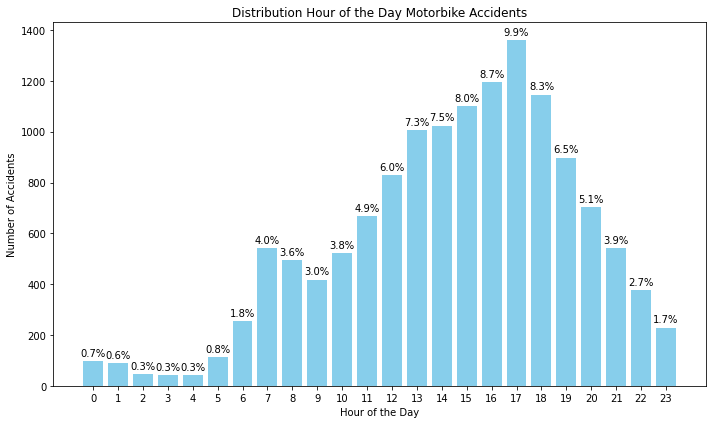

In [13]:
#hourly the Day for Motorbike Accidents distribution
distribution_plot(motorbike_df, 'hour', range(24),
                  'Distribution Hour of the Day Motorbike Accidents',
                  'Hour of the Day', 'Number of Accidents',
                  x_ticks=range(24), x_tick_labels=range(24),
                  colors = 'skyblue', save_path="motorbike_accident.png")

**Interpretation:**
The plot representing motorcycle accidents mirrors the trend observed in the overall accident distribution. It shows a consistent pattern where accidents gradually increase from 5:00 AM, reaching a peak at 5:00 PM with 9.9% accidents. After this peak, accident counts decline until reaching their lowest(0.3%) point around 4:00 AM, before rising again.

This trend may be attributed to several factors. The increase in accidents from 5:00 AM onwards corresponds to the morning rush hour, when traffic volumes surge as commuters head to work, leading to a higher likelihood of accidents. The peak at 5:00 PM aligns with the evening rush hour, another period of heightened traffic activity as people return home from work. The decreasing trend in accidents from the evening peak until the early morning hours likely reflects reduced traffic during nighttime, when fewer motorcycles are on the road.

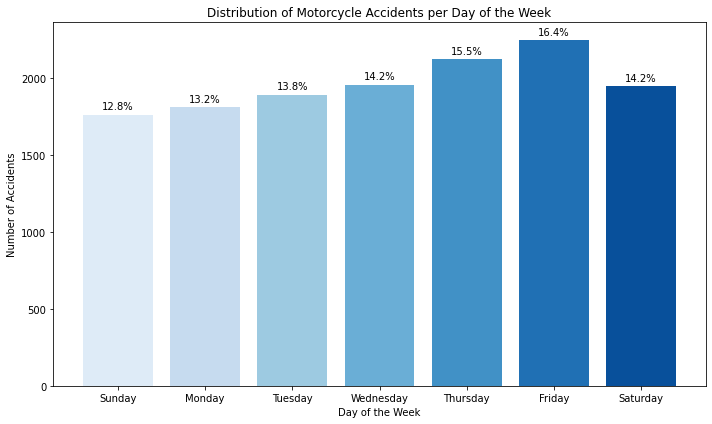

In [14]:
# daily Percentage of Accidents per Day of the Week
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
distribution_plot(motorbike_df, 'day_of_week', days,
                  'Distribution of Motorcycle Accidents per Day of the Week',
                  'Day of the Week', 'Number of Accidents', 
                  save_path="Motorbikeweek.png"
                 ,colormap = 'Blues')


**Interpretation:**
The barplot for motorcycle accidents by day of the week follows a similar trend to the overall accident distribution.

Friday records the highest number of accidents, with 16.4% occurrences, followed closely by Thursday with 15.5% accidents. Wednesday and Tuesday show slightly fewer accidents but still exhibit increased occurrences during the middle of the week. Monday continues the trend of higher accidents at the beginning of the week, while Saturday has a lower accident count compared to weekdays. Sunday records the lowest number of accidents, with 12.8% occurrences.

In summary, the analysis reveals a clear pattern of higher accident rates during weekdays, particularly on Fridays and Thursdays. Weekends, especially Sundays, see fewer accidents, likely due to reduced work-related travel and more leisure-oriented driving. These findings can inform road safety measures and traffic management strategies, emphasizing accident-prone days to enhance overall safety.

## **3. Hours of the Days and days of the Week for pedestrian**

For this task, we'll extract crucial attributes from the accident and casualty tables, including the accident index, time, casualty class, and the day of the week. One key step creating the hour feature from the time attribute. The casualty class feature, which outlines the various casualty classes involved in accidents, is particularly relevant.

Our analysis will focus on pedestrian accidents, corresponding to code 3 in the STATS 20 document. We'll extract and visually represent accident data related to pedestrian incidents. This approach will allow us to examine the distribution of pedestrian accidents based on both the hour of occurrence and the day of the week.

In [15]:
# Extracting relevant columns and merging the accident table with the casualty table
cursor.execute("""
SELECT a.accident_index, a.time, a.day_of_week, c.casualty_class
FROM Accident a
JOIN Casualty c ON a.accident_index = c.accident_index
WHERE a.accident_year = 2020;
""")
ac_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results
columns = ['accident_index', 'time', 'day_of_week', 'casualty_class']
acC_df = pd.DataFrame(
    ac_data,
    columns=['accident_index', 'time', 'day_of_week', 'casualty_class'])

acC_df.head(5)

accident_index   time  day_of_week  casualty_class
0  2020010219808  09:00            3               3
1  2020010220496  13:55            2               3
2  2020010220496  13:55            2               3
3  2020010228005  01:25            4               3
4  2020010228006  01:50            4               3

In [16]:
# Filtering data for pedestrian accidents
pedestrian_df = acC_df[acC_df['casualty_class'] == 3].copy()
pedestrian_df['hour'] = pd.to_datetime(pedestrian_df['time'], format="%H:%M").dt.hour

# Displaying the dataframe
pedestrian_df.head(5)

accident_index   time  day_of_week  casualty_class  hour
0  2020010219808  09:00            3               3     9
1  2020010220496  13:55            2               3    13
2  2020010220496  13:55            2               3    13
3  2020010228005  01:25            4               3     1
4  2020010228006  01:50            4               3     1

In [17]:
# Checking the value counts of accident index feature
pedestrian_df["accident_index"].value_counts()

2020010266513    8
2020100966861    5
2020010234510    5
2020137C90269    4
2020200974011    4
                ..
202006P179189    1
202006P269860    1
202006P270350    1
202006P275388    1
2020991032575    1
Name: accident_index, Length: 14193, dtype: int64

The showing outcomes indicates the presence the replicated entries within the accident_index columns of the merged tables. This duplication arises due to the combination of data from the accident and casualty tables. Now we need to eliminate the duplicates values

In [18]:
# Dropping the rows with duplicate 'accident_index'
pedestrian_df = pedestrian_df.drop_duplicates(subset='accident_index', keep='first')

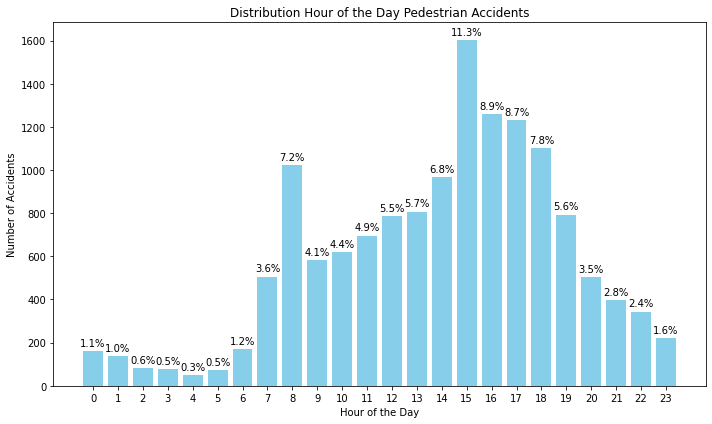

In [19]:
#'Significant Hour of the Day for Pedestrian Accidents Occurrence'
distribution_plot(pedestrian_df, 'hour', range(24),
                  'Distribution Hour of the Day Pedestrian Accidents',
                  'Hour of the Day', 'Number of Accidents',
                  x_ticks=range(24), x_tick_labels=range(24),
                  colors = 'skyblue',save_path="pedestrian.png")

**Interpretation:**
The plot shows a clear trend in pedestrian accidents over the course of the day. Accidents steadily rise from 5:00 AM to 3:00 PM(15:00 PM), reaching a peak at 3:00 PM(15:00 PM) before gradually decreasing until 4:00 AM. The notable peak at 3:00 PM (15:00 PM)suggests that this time period experiences the highest number of pedestrian accidents, likely due to increased pedestrian activity during daylight hours. The relatively lower number of accidents between 1:00 AM and 4:00 AM may be due to reduced pedestrian movement during these early morning hours.

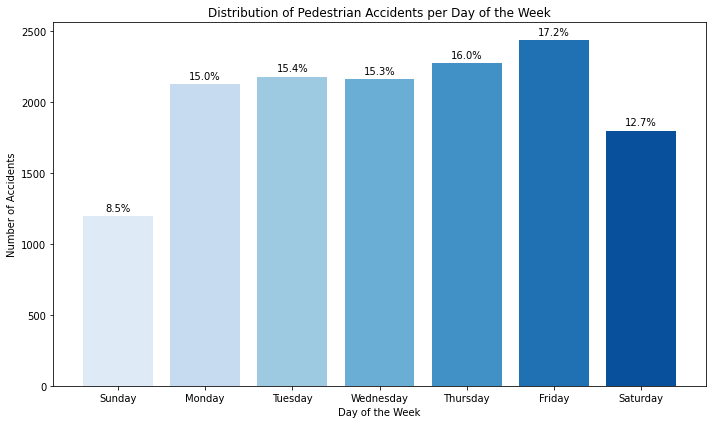

In [20]:
# Distribution of Pedestrian Accidents per Day of the Week
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
distribution_plot(pedestrian_df, 'day_of_week', days,
                  'Distribution of Pedestrian Accidents per Day of the Week',
                  'Day of the Week', 'Number of Accidents',
                  colormap = 'Blues',save_path="pedestrianW.png")

**Interpretation:**
The barplot depicting pedestrian accidents by day of the week reveals a consistent pattern similar to the overall accident distribution.

Friday emerges as the day with the highest count of pedestrian accidents, totaling 17.2% incidents. This peak likely corresponds to increased pedestrian activity at the start of the weekend. Thursday follows closely behind with 16% accidents, indicating a trend of elevated pedestrian accidents towards the end of the workweek. Wednesday and Tuesday show slightly lower accident counts (15.3% and 15.4% respectively), suggesting continued pedestrian involvement during the middle of the week. Monday's pedestrian accidents (15%) align with the overall pattern of higher accidents at the beginning of the week, possibly due to increased commuter traffic. Saturday records fewer pedestrian accidents (12.7%), reflecting reduced weekday work-related activity. Sunday exhibits the lowest pedestrian accident count (8.5%), likely due to decreased overall activity and fewer pedestrians on weekends.

## **4. Apriori algorithm: Impact of selected variables on accident severty**

We'll extract key attributes from accidents such as weather conditions, speed limit, light conditions,urban_or_rural_area, road_surface_conditions and accident severity. Our goal is to evaluate how these variables influence accident severity using the Apriori algorithm. We'll one-hot encode each variable and then apply the Apriori algorithm to establish association rules.

In [21]:
# Extracting relevant columns
cursor.execute("""
SELECT a.weather_conditions, a.speed_limit, a.light_conditions, a.urban_or_rural_area, a.road_surface_conditions,a.accident_severity
FROM Accident a
WHERE a.accident_year = 2020;
""")
apriori_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results
columns = ['weather_conditions', 'speed_limit', 'light_conditions', 'urban_or_rural_area','road_surface_conditions', 'accident_severity']
apriori_df = pd.DataFrame(
    apriori_data,
    columns= columns)
apriori_df.head()

weather_conditions  speed_limit  light_conditions  urban_or_rural_area  \
0                   9           20                 1                    1   
1                   1           20                 1                    1   
2                   1           30                 4                    1   
3                   1           30                 4                    1   
4                   1           30                 4                    1   

   road_surface_conditions  accident_severity  
0                        9                  3  
1                        1                  3  
2                        2                  3  
3                        1                  2  
4                        1                  3

In [22]:
columns=['weather_conditions', 'speed_limit', 'light_conditions','urban_or_rural_area', 'road_surface_conditions','accident_severity']
for column in columns:
    unique_values = apriori_df[column].unique()
    print(f"{column}: {unique_values}")



weather_conditions: [ 9  1  8  7  2  4  5  3  6 -1]
speed_limit: [20 30 40 50 60 70 -1]
light_conditions: [ 1  4  5  7  6 -1]
urban_or_rural_area: [1 2 3]
road_surface_conditions: [ 9  1  2  5  4  3 -1]
accident_severity: [3 2 1]


In [23]:
# One-hot encoding for the accident_severity feature
a_severity = pd.get_dummies(apriori_df.accident_severity, prefix = 'severity')

# One-hot encoding for the weather_conditions feature
weather_con = pd.get_dummies(apriori_df.weather_conditions, prefix = 'weather')

# One-hot encoding for the light_conditions feature
light_con = pd.get_dummies(apriori_df.light_conditions, prefix = 'light')
# One-hot encoding for the urban or rural feature
ur_area = pd.get_dummies(apriori_df.urban_or_rural_area, prefix = 'ur')
# One-hot encoding for the road_surface_condition feature
rs_con = pd.get_dummies(apriori_df.road_surface_conditions, prefix = 'road_surface_conditions')

# One-hot encoding for the speed_limit feature
speed_limit = pd.get_dummies(apriori_df.speed_limit, prefix = 'speed')

# Concatenating the dataframes along the columns
combined_df = pd.concat([a_severity, weather_con,light_con,ur_area,rs_con,speed_limit], axis=1)
combined_df

severity_1  severity_2  severity_3  weather_-1  weather_1  weather_2  \
0               0           0           1           0          0          0   
1               0           0           1           0          1          0   
2               0           0           1           0          1          0   
3               0           1           0           0          1          0   
4               0           0           1           0          1          0   
...           ...         ...         ...         ...        ...        ...   
91194           0           1           0           0          1          0   
91195           0           0           1           0          1          0   
91196           0           1           0           0          1          0   
91197           0           0           1           0          1          0   
91198           0           0           1           0          1          0   

       weather_3  weather_4  weather_5  weather_6  ...  \
0              0          0          0          0  ...   
1              0          0          0          0  ...   
2              0          0          0          0  ...   
3              0          0          0          0  ...   
4              0          0          0          0  ...   
...          ...        ...        ...        ...  ...   
91194          0          0          0          0  ...   
91195          0          0          0          0  ...   
91196          0          0          0          0  ...   
91197          0          0          0          0  ...   
91198          0          0          0          0  ...   

       road_surface_conditions_4  road_surface_conditions_5  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   
...                          ...                        ...   
91194                          0                          0   
91195                          0                          0   
91196                          0                          0   
91197                          0                          0   
91198                          0                          0   

       road_surface_conditions_9  speed_-1  speed_20  speed_30  speed_40  \
0                              1         0         1         0         0   
1                              0         0         1         0         0   
2                              0         0         0         1         0   
3                              0         0         0         1         0   
4                              0         0         0         1         0   
...                          ...       ...       ...       ...       ...   
91194                          0         0         0         1         0   
91195                          0         0         0         1         0   
91196                          0         0         0         0         0   
91197                          0         0         0         1         0   
91198                          0         0         0         1         0   

       speed_50  speed_60  speed_70  
0             0         0         0  
1             0         0         0  
2             0         0         0  
3             0         0         0  
4             0         0         0  
...         ...       ...       ...  
91194         0         0         0  
91195         0         0         0  
91196         0         1         0  
91197         0         0         0  
91198         0         0         0  

[91199 rows x 36 columns]

In [24]:
# Running Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(combined_df, min_support=0.2, use_colnames=True)

In [25]:
# Running association rules to find patterns
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)

# Displaying the rules
rules

antecedents  \
0                   (severity_3)   
1                    (weather_1)   
2                   (severity_3)   
3                      (light_1)   
4                         (ur_1)   
..                           ...   
607                 (severity_3)   
608                       (ur_1)   
609  (road_surface_conditions_1)   
610                    (light_1)   
611                  (weather_1)   

                                           consequents  antecedent support  \
0                                          (weather_1)            0.783484   
1                                         (severity_3)            0.775546   
2                                            (light_1)            0.783484   
3                                         (severity_3)            0.706784   
4                                         (severity_3)            0.676948   
..                                                 ...                 ...   
607  (speed_30, ur_1, road_surface_conditions_1, li...            0.783484   
608  (speed_30, severity_3, road_surface_conditions...            0.676948   
609   (speed_30, severity_3, ur_1, light_1, weather_1)            0.687486   
610  (speed_30, severity_3, ur_1, road_surface_cond...            0.706784   
611  (speed_30, severity_3, ur_1, road_surface_cond...            0.775546   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.775546  0.603186    0.769877  0.992690 -0.004442    0.975365   
1              0.783484  0.603186    0.777757  0.992690 -0.004442    0.974230   
2              0.706784  0.559337    0.713910  1.010082  0.005583    1.024907   
3              0.783484  0.559337    0.791384  1.010082  0.005583    1.037864   
4              0.783484  0.550313    0.812932  1.037586  0.019935    1.157418   
..                  ...       ...         ...       ...       ...         ...   
607            0.253555  0.205770    0.262634  1.035806  0.007113    1.012312   
608            0.241231  0.205770    0.303967  1.260067  0.042469    1.090134   
609            0.231450  0.205770    0.299308  1.293186  0.046651    1.096844   
610            0.263479  0.205770    0.291135  1.104967  0.019547    1.039015   
611            0.218950  0.205770    0.265323  1.211797  0.035964    1.063120   

     zhangs_metric  
0        -0.032891  
1        -0.031765  
2         0.046100  
3         0.034041  
4         0.112131  
..             ...  
607       0.159656  
608       0.638880  
609       0.725458  
610       0.323978  
611       0.778684  

[612 rows x 10 columns]

In [26]:
# Sort rules by confidence level in descending order
sorted_rules = rules.sort_values(by='confidence', ascending=False)

# Filter rules where the consequent is associated with "slight" accident severity
slight_rules = sorted_rules[sorted_rules['consequents'].apply(lambda x: any(item in x for item in ['severity_1', 'severity_2', 'severity_3']))]

# Select the top 5 rules with highest confidence
top_5_rules = slight_rules.head(5)

#better display column width
pd.set_option('display.max_colwidth', None)

# Display the top 5 rules
top_5_rules



antecedents   consequents  \
65                                         (ur_1, light_1)  (severity_3)   
245             (ur_1, road_surface_conditions_1, light_1)  (severity_3)   
260                              (ur_1, light_1, speed_30)  (severity_3)   
374  (ur_1, road_surface_conditions_1, light_1, weather_1)  (severity_3)   
162                             (ur_1, light_1, weather_1)  (severity_3)   

     antecedent support  consequent support   support  confidence      lift  \
65             0.473536            0.783484  0.389379    0.822280  1.049517   
245            0.369204            0.783484  0.302141    0.818360  1.044513   
260            0.344730            0.783484  0.281922    0.817806  1.043806   
374            0.346670            0.783484  0.282733    0.815568  1.040950   
162            0.389193            0.783484  0.317262    0.815180  1.040455   

     leverage  conviction  zhangs_metric  
65   0.018371    1.218298       0.089618  
245  0.012876    1.192004       0.067560  
260  0.011832    1.188378       0.064046  
374  0.011122    1.173959       0.060213  
162  0.012336    1.171494       0.063656

Here are the insights drawn from the association rules:

1. **Association between Urban, Light Condition 1 and Slight Severity (severity_3):**
   - Support: 0.389, Confidence: 0.822, Lift: 1.050
   - This association suggests that accidents occurring in urban areas under light condition 1 are highly likely to result in slight severity.

2. **Association between Urban, Road Surface Condition 1, Light Condition 1 and Slight Severity (severity_3):**
   - Support: 0.302, Confidence: 0.818, Lift: 1.045
   - Accidents happening in urban areas with road surface condition 1 and light condition 1 are significantly associated with slight severity.

3. **Association between Urban, Speed Limit 30, Light Condition 1 and Slight Severity (severity_3):**
   - Support: 0.282, Confidence: 0.818, Lift: 1.044
   - This association indicates that accidents in urban areas with a speed limit of 30 and light condition 1 have a high likelihood of resulting in slight severity.

4. **Association between Urban, Road Surface Condition 1, Weather Condition 1, Light Condition 1 and Slight Severity (severity_3):**
   - Support: 0.283, Confidence: 0.816, Lift: 1.041
   - Accidents occurring in urban areas with road surface condition 1, weather condition 1, and light condition 1 are associated with slight severity.

5. **Association between Urban, Weather Condition 1, Light Condition 1 and Slight Severity (severity_3):**
   - Support: 0.317, Confidence: 0.815, Lift: 1.040
   - This association suggests that accidents in urban areas with weather condition 1 and light condition 1 are highly likely to result in slight severity.


#### **Representative Apriori association**



| Rule | Association | Support | Confidence | Lift |
|------|-------------|---------|------------|------|
| 1    | {Urban, Daylight} => {Slight} | 0.389 | 0.822 | 1.049 |
| 2    | {Urban, Dry_road, Daylight} => {Slight} | 0.302 | 0.818 | 1.044 |
| 3    | {Urban, Speed_30, Daylight} => {Slight} | 0.281 | 0.817 | 1.043 |
| 4    | {Urban, Dry_road, Fine without high winds, Daylight} => {Slight} | 0.282 | 0.815 | 1.040 |
| 5    | {Urban, Fine without high winds, Daylight} => {Slight} | 0.317 | 0.815 | 1.040 |



## **5. Clustering: Identifying accidents in Kingston upon Hull, Humberside, East riding of Yorkshire etc.**

For this task, the first step will be to extract essential attributes from both the accident and lsoa tables. These attributes encompass the accident index, longitude, latitude, police force and lsoa01nm.

In [27]:
# Execute the SQL query to retrieve accident data
cursor.execute("""
SELECT a.accident_index, a.longitude, a.latitude, a.police_force, l.lsoa01nm
FROM Accident a
JOIN LSOA l ON a.lsoa_of_accident_location = l.lsoa01cd
WHERE a.police_force = 16 AND a.accident_year = 2020;
""")
accidents_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results
columns = ['accident_index', 'longitude', 'latitude', 'police_force', 'lsoa01nm']
clustering_df = pd.DataFrame(accidents_data, columns=columns)
# Displaying the dataframe
clustering_df.head()

accident_index  longitude   latitude  police_force  \
0  2020160914930  -0.393424  53.744936            16   
1  2020160915008  -0.528743  53.512895            16   
2  2020160915028  -0.324858  53.791630            16   
3  2020160915041  -0.095008  53.574501            16   
4  2020160915047  -0.327733  53.767805            16   

                       lsoa01nm  
0       Kingston upon Hull 028E  
1       North Lincolnshire 022C  
2       Kingston upon Hull 002E  
3  North East Lincolnshire 003C  
4       Kingston upon Hull 016D

In [28]:
# Dropping the missing values in the longitude and latitude features
clustering_df.dropna(subset=['longitude', 'latitude'], inplace=True)

In [29]:
# Selecting the features for the clustering
coordinates = clustering_df[['latitude', 'longitude']]

#### **selecting cluster using Elbow method**

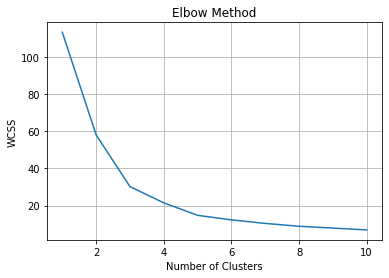

In [30]:
# Using Elbow Method to select the best cluster number
wcss = []
for i in range(1,11):
    model = KMeans(n_clusters=i, n_init = 10)
    y_means = model.fit_predict(coordinates)
    wcss.append(model.inertia_)

# Visualising the Elbow Method
plt.plot(range(1, 11), wcss)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.grid()
# Save the figure
plt.savefig('Elbow Method.png', bbox_inches='tight')
plt.show()    

From the elbow method above figure, 5 is considered to be the most suitable number of clusters to be used for the clustering analysis.

In [31]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, n_init = 10, random_state=42)
kmeans.fit(coordinates)
clustering_df['Cluster'] = kmeans.labels_


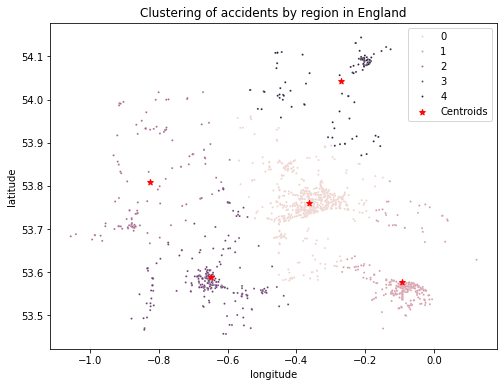

In [32]:
# Plot the scatterplot with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clustering_df, x='longitude', y='latitude',s=4, hue='Cluster')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 1], centroids[:, 0], marker='*', color='red', label='Centroids', cmap='viridis')
plt.legend()
plt.title('Clustering of accidents by region in England')
# Save the figure
plt.savefig('Clustering of accidents by region in England.png', bbox_inches='tight')
plt.show()


#### **Analyzing the region cluster**

In [33]:
# Analyzing the clusters
cluster_counts = clustering_df['Cluster'].value_counts()
print("Number of accidents in each cluster:")
print(cluster_counts)


Number of accidents in each cluster:
0    831
1    333
3    261
2    128
4    110
Name: Cluster, dtype: int64


In [34]:
def analyze_cluster_regions(clustering_df):
    cluster_counts = {}

    for cluster_num in range(5):
        cluster = clustering_df[clustering_df["Cluster"]==cluster_num]
        cluster_counts[cluster_num] = {
            "East Riding of Yorkshire": len(cluster[cluster["lsoa01nm"].str.startswith("East Riding of Yorkshire")]),
            "Kingston upon Hull": len(cluster[cluster["lsoa01nm"].str.startswith("Kingston upon Hull")]),
            "North East Lincolnshire": len(cluster[cluster["lsoa01nm"].str.startswith("North East Lincolnshire")]),
            "North Lincolnshire": len(cluster[cluster["lsoa01nm"].str.startswith("North Lincolnshire")])
        }

    for cluster_num, region_counts in cluster_counts.items():
        print(f"Cluster {cluster_num}:")
        for region, count in region_counts.items():
            print(f"{region}: {count}")
        print("-----------------------------------------------------------------------------------")

print("The value counts of regions across the 5 clusters:")
print("-----------------------------------------------------------------------------------")


analyze_cluster_regions(clustering_df)

The value counts of regions across the 5 clusters:
-----------------------------------------------------------------------------------
Cluster 0:
East Riding of Yorkshire: 196
Kingston upon Hull: 569
North East Lincolnshire: 3
North Lincolnshire: 63
-----------------------------------------------------------------------------------
Cluster 1:
East Riding of Yorkshire: 31
Kingston upon Hull: 0
North East Lincolnshire: 299
North Lincolnshire: 3
-----------------------------------------------------------------------------------
Cluster 2:
East Riding of Yorkshire: 128
Kingston upon Hull: 0
North East Lincolnshire: 0
North Lincolnshire: 0
-----------------------------------------------------------------------------------
Cluster 3:
East Riding of Yorkshire: 23
Kingston upon Hull: 0
North East Lincolnshire: 0
North Lincolnshire: 238
-----------------------------------------------------------------------------------
Cluster 4:
East Riding of Yorkshire: 110
Kingston upon Hull: 0
North East Li

The analysis reveals that clusters 2 and 4 stand out for their clear concentration of data points exclusively from the East Riding of Yorkshire region. In contrast, the other clusters show a mix of data points across all four regions within the Humberside area. Notably, each region is prominently represented in at least one cluster, emphasizing the informative nature of these clusters. Visualizations will further elucidate the composition of these clusters, offering a more comprehensive understanding of their distribution.

In [35]:
# Calculating the average latitude and longitude
average_latitude = clustering_df['latitude'].mean()
average_longitude = clustering_df['longitude'].mean()

# Creating a map centered around the average coordinates
map_center = [average_latitude, average_longitude]
map = folium.Map(location=map_center, zoom_start=10, tiles="openstreetmap")

# Define colors for each cluster
colors = ["blue", "red", "green", "brown", "grey"]

# Adding circle markers for each cluster
for i in range(5):
    cluster = clustering_df[clustering_df['Cluster'] == i]
    for _, point in cluster.iterrows():
        folium.CircleMarker([point['latitude'], point['longitude']], radius=2, color=colors[i], fill_color=f"light{colors[i]}").add_to(map)

#save the picture
img_data = map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')        
        
# Displaying the map
map



The map highlights significant clusters of accidents across different regions:

- **Red Cluster**: Predominantly, accidents cluster around Grimsby in North East Lincolnshire. However, there are also minor concentrations in Immingham and Withernsea in the East Riding of Yorkshire.

- **Brown Cluster**: The primary cluster centers around Scunthorpe in North Lincolnshire, with additional minor occurrences in Brigg, Epworth, South Cave, Crowle, and Kirton in Lindsey.

- **Blue Cluster**: Hull, situated in Kingston Upon Hull, serves as the primary focal point for accidents in this cluster. Minor incidents also occur in Beverly, Barton-upon-Humber, and Hedon.

- **Green Cluster**: Goole, located in the East Riding of Yorkshire, experiences a majority of accidents in this cluster. Pocklington and Howden also register minor accident occurrences.

- **Grey Cluster**: Bridlington, within the East Riding of Yorkshire, constitutes the primary accident cluster. Driffield and Hornsea also witness minor accident incidents.


#### **Folium map displaying accident locations, with markers color-coded based on the clusters**

In [36]:
map_center = [clustering_df['latitude'].mean(), clustering_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB positron')

# Using MarkerCluster to group markers for performance
marker_cluster = MarkerCluster().add_to(m)

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Adding markers for each accident, color-coded by cluster
for _, row in clustering_df.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        icon=folium.Icon(color=colors[row['Cluster']], icon_size=(10, 10)),
        popup=row['accident_index'],
    ).add_to(marker_cluster)
#save the picture
img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('displaying accident locations.png')

# Displaying the map
m


## **6. Outlier Detections: Identifying unusual entries in the data sets**

In [37]:
# Read tables from the database into DataFrames
accident_df = pd.read_sql_query("SELECT * FROM accident WHERE accident_year = 2020", conn)
vehicle_df = pd.read_sql_query("SELECT * FROM vehicle WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020)", conn)
casualty_df = pd.read_sql_query("SELECT * FROM casualty WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020)", conn)

The presented tables make it apparent that a significant portion of the features are encoded rather than continuous. Consequently, the focus of outlier detection will be solely on pertinent continuous attributes. Notably, this includes the longitude and latitude in the accident table, along with the age of driver and age of vehicle in the vehicle table.

**Age of vihicle Distribution**

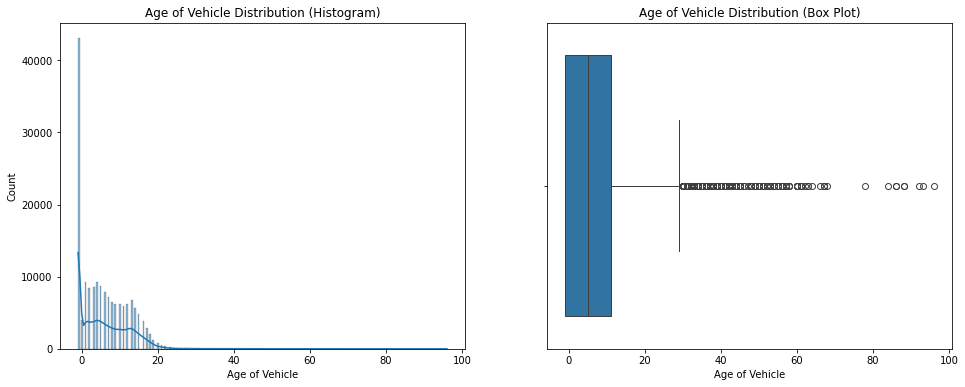

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(x=vehicle_df["age_of_vehicle"], data=vehicle_df, kde=True, ax=axes[0])
axes[0].set_title("Age of Vehicle Distribution (Histogram)")
axes[0].set_xlabel("Age of Vehicle")

# Box plot
sns.boxplot(x=vehicle_df["age_of_vehicle"], ax=axes[1])
axes[1].set_title("Age of Vehicle Distribution (Box Plot)")
axes[1].set_xlabel("Age of Vehicle")
plt.savefig('vehicle_distribution.png')
plt.show()

The histogram plot and box plot highlights the presence of outliers within the age of vehicle distribution. This observation warrants a deeper investigation as part of the analysis process.

**Age of driver distribution**

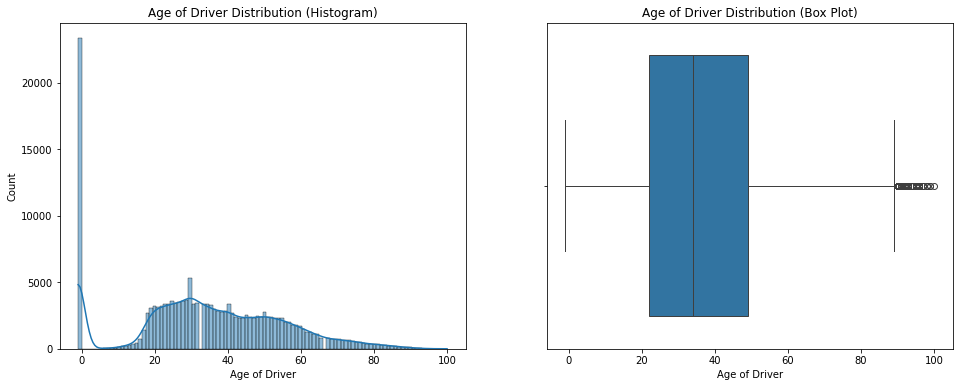

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(x=vehicle_df["age_of_driver"], data=vehicle_df, kde=True, ax=axes[0])
axes[0].set_title("Age of Driver Distribution (Histogram)")
axes[0].set_xlabel("Age of Driver")

# Box plot
sns.boxplot(x=vehicle_df["age_of_driver"], ax=axes[1])
axes[1].set_title("Age of Driver Distribution (Box Plot)")
axes[1].set_xlabel("Age of Driver")
plt.savefig('DriverAge_distribution.png')
plt.show()

The histogram plot and box plot highlights the presence of outliers within the age of driver distribution. This observation warrants a deeper investigation as part of the analysis process.

#### **Outlier detection vehicle table**

Using IQR Test and Grubbs'Test will be conducted to detect outliers in the vehicle table

**IQR method to detect outliers**

In [40]:
# Define a function to detect outliers using IQR method
def detect_outliers_iqr(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr_range = q3 - q1
    lower_bound = q1 - 1.5 * iqr_range
    upper_bound = q3 + 1.5 * iqr_range
    print1 = print("lower_bound:", lower_bound)
    print2 = print("lower_bound:", upper_bound)
    return (column < lower_bound) | (column > upper_bound)
    return print1
    return print2

**Age of Drivers**

In [41]:
# Create DataFrames to store outliers detected using IQR method
outliers_age_of_driver = vehicle_df[detect_outliers_iqr(vehicle_df['age_of_driver'])]

print("Outliers detected using IQR method for 'age_of_driver':")
outliers_age_of_driver

lower_bound: -18.5
lower_bound: 89.5
Outliers detected using IQR method for 'age_of_driver':


vehicle_index accident_index  accident_year accident_reference  \
1802           683518  2020010231441           2020          010231441   
2071           683787  2020010231896           2020          010231896   
2463           684179  2020010232619           2020          010232619   
2646           684362  2020010232979           2020          010232979   
3030           684746  2020010233661           2020          010233661   
...               ...            ...            ...                ...   
164223         845939  2020990969062           2020          990969062   
164561         846277  2020990972908           2020          990972908   
165071         846787  2020990978759           2020          990978759   
165970         847686  2020990991630           2020          990991630   
166819         848535  2020991004453           2020          991004453   

        vehicle_reference  vehicle_type  towing_and_articulation  \
1802                    2             9                        0   
2071                    1             9                        0   
2463                    1             9                        0   
2646                    1             9                        0   
3030                    1             9                        0   
...                   ...           ...                      ...   
164223                  1             9                        0   
164561                  1             9                        0   
165071                  1             9                        0   
165970                  1            19                        0   
166819                  1             9                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
1802                   18                       3                     7  ...   
2071                    5                       5                     1  ...   
2463                   18                       2                     6  ...   
2646                    9                       5                     3  ...   
3030                   99                       9                     9  ...   
...                   ...                     ...                   ...  ...   
164223                 18                       6                     2  ...   
164561                  9                       6                     2  ...   
165071                  4                       5                     8  ...   
165970                  2                       0                     0  ...   
166819                 18                       5                     1  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
1802                            6              1             90   
2071                            6              1             91   
2463                            6              1             90   
2646                            6              1             91   
3030                            6              3             93   
...                           ...            ...            ...   
164223                          5              1             90   
164561                          5              1             96   
165071                          6              1             92   
165970                          6              1             90   
166819                          5              1             91   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
1802                    11                1388                1   
2071                    11                1596                1   
2463                    11                1998                1   
2646                    11                1591                1   
3030                    11                1389                1   
...                    ...                 ...              ...   
164223                  11                1598                2   


In [42]:
# Displaying the unique values in the outliers
print("The unique values of the outliers in the age of driver identified by the IQR Test:")
np.sort(outliers_age_of_driver["age_of_driver"].unique())

The unique values of the outliers in the age of driver identified by the IQR Test:


array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

The output indicates that the outliers in the age of drivers identified by the IQR Test range from 90 to 100 years old. These ages are considered unusual or extreme compared to the majority of the dataset, suggesting that there may be errors or unusual cases within this age group.

**Age of vehicle**

In [43]:
# Create DataFrames to store outliers detected using IQR method
outliers_age_of_vehicle = vehicle_df[detect_outliers_iqr(vehicle_df['age_of_vehicle'])]

print("Outliers detected using IQR method for 'age_of_vehicle':")
outliers_age_of_vehicle

lower_bound: -19.0
lower_bound: 29.0
Outliers detected using IQR method for 'age_of_vehicle':


vehicle_index accident_index  accident_year accident_reference  \
847            682563  2020010229701           2020          010229701   
1822           683538  2020010231465           2020          010231465   
3450           685166  2020010234271           2020          010234271   
3884           685600  2020010234969           2020          010234969   
5090           686806  2020010237020           2020          010237020   
...               ...            ...            ...                ...   
165468         847184  2020990984616           2020          990984616   
165498         847214  2020990984765           2020          990984765   
166020         847736  2020990992686           2020          990992686   
166180         847896  2020990994835           2020          990994835   
166704         848420  2020991002465           2020          991002465   

        vehicle_reference  vehicle_type  towing_and_articulation  \
847                     1             9                        0   
1822                    2            90                        0   
3450                    2             9                        0   
3884                    1             4                        0   
5090                    1             5                        0   
...                   ...           ...                      ...   
165468                  1             9                        0   
165498                  1             3                        0   
166020                  2            17                        0   
166180                  1             9                        0   
166704                  2            90                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
847                    99                       9                     9  ...   
1822                   18                       7                     3  ...   
3450                    5                       5                     1  ...   
3884                   18                       1                     5  ...   
5090                   18                       4                     8  ...   
...                   ...                     ...                   ...  ...   
165468                 16                       6                     2  ...   
165498                  4                       4                     8  ...   
166020                 10                       1                     5  ...   
166180                  2                       0                     0  ...   
166704                 18                       5                     1  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
847                             6              1             45   
1822                            6              1             -1   
3450                            6              1             51   
3884                            6              1             25   
5090                            2              1             23   
...                           ...            ...            ...   
165468                          5              1             74   
165498                          6              1             27   
166020                          1              1             57   
166180                          5              1             23   
166704                          5              1             53   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
847                      7                1108                1   
1822                    -1                1971                1   
3450                     8                2299                1   
3884                     5                 400                1   
5090                     5                 500                1   
...                    ...                 ...              ...   
165468                  10                3781                1   


In [44]:
# Displaying the unique values in the outliers
print("The unique values of the outliers in the age of vehicle identified by the IQR Test:")
np.sort(outliers_age_of_vehicle["age_of_vehicle"].unique())

The unique values of the outliers in the age of vehicle identified by the IQR Test:


array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64,
       66, 67, 68, 78, 84, 86, 88, 92, 93, 96], dtype=int64)

The data analysis uncovered 324 data points flagged as outliers using the IQR Test. These outliers exhibit distinct attributes, suggesting their potential authenticity. For instance, instances where the reported vehicle age is 30 years or older might indeed be valid, considering the typical lifespan of vehicles in the United Kingdom.

Given their relatively small number, it is reasonable to consider excluding these outliers from the vehicle dataframe. Their removal is unlikely to substantially impact our analysis.

#### **Grubbs test**

Grubbs' test, also referred to as the ESD (Extreme Studentized Deviate) method, serves as a statistical tool for identifying outliers within normally distributed datasets. The procedure involves assessing the deviation of an outlier from the rest of the data points by determining the maximum absolute difference between the values and the mean. This difference is then normalized by dividing it by the standard deviation. The resulting ratio, denoted as Z, represents the extent to which a value deviates from the others. If Z exceeds a certain threshold, indicating a large deviation, the value is deemed an outlier.

In [45]:
a_age_of_driver = vehicle_df["age_of_driver"]
a_age_of_vehicle = vehicle_df["age_of_vehicle"]

# Compute the mean and standard deviation for both features
avg_age_of_driver = np.mean(a_age_of_driver)
avg_age_of_vehicle = np.mean(a_age_of_vehicle)
stdev_age_of_driver = np.std(a_age_of_driver)
stdev_age_of_vehicle = np.std(a_age_of_vehicle)

# Compute the absolute value of x(i) - avg(x)
absvalues_age_of_driver = abs(a_age_of_driver - avg_age_of_driver)
absvalues_age_of_vehicle = abs(a_age_of_vehicle - avg_age_of_vehicle)

# Obtain the maximum value of the absvalues
maxvalue_age_of_driver = max(absvalues_age_of_driver)
maxvalue_age_of_vehicle = max(absvalues_age_of_vehicle)

# Compute the G value from the above
Grubbs_age_of_driver = maxvalue_age_of_driver / stdev_age_of_driver
Grubbs_age_of_vehicle = maxvalue_age_of_vehicle / stdev_age_of_vehicle

print("Grubbs value for age_of_driver:", Grubbs_age_of_driver)
print("Grubbs value for age_of_vehicle:", Grubbs_age_of_vehicle)

# Compute the critical value of G needed to accept or reject H0
def get_critical_G(size, alpha):
    tdist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(tdist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(tdist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

# Determining the critical parameter for the data
Gcritical_age_of_driver = get_critical_G(len(a_age_of_driver), 0.05)
Gcritical_age_of_vehicle = get_critical_G(len(a_age_of_vehicle), 0.05)

# Detect outliers using the Grubbs test and create boolean masks
outliers_mask_age_of_driver = abs(a_age_of_driver - avg_age_of_driver) > Gcritical_age_of_driver * stdev_age_of_driver
outliers_mask_age_of_vehicle = abs(a_age_of_vehicle - avg_age_of_vehicle) > Gcritical_age_of_vehicle * stdev_age_of_vehicle

# Filter the DataFrame to get outliers for both features
outliers_df_age_of_driver = vehicle_df[outliers_mask_age_of_driver]
outliers_df_age_of_vehicle = vehicle_df[outliers_mask_age_of_vehicle]


Grubbs value for age_of_driver: 3.14895940018594
Grubbs value for age_of_vehicle: 14.242053069432727
Grubbs Critical Value: 5.124052908584172
Grubbs Critical Value: 5.124052908584172


Interpretation:

Regarding the "age_of_driver" feature: The Grubbs value (3.14895940018594) falls below the Grubbs Critical Value (5.124052908584172), suggesting that the extreme value in the "age_of_driver" data does not significantly deviate from the mean. Hence, it is not considered an outlier according to the Grubbs test.

As for the "age_of_vehicle" feature: The Grubbs value (14.242053069432727) greatly exceeds the Grubbs Critical Value (5.124052908584172). This stark difference indicates a significant deviation of the most extreme value in the "age_of_vehicle" data from the mean. Thus, it could be deemed an outlier based on the Grubbs test.

In [46]:
# Display the DataFrames containing outliers for the Age of Driver feature
print("Outliers in age_of_driver:")
outliers_df_age_of_driver


Outliers in age_of_driver:


Empty DataFrame
Columns: [vehicle_index, accident_index, accident_year, accident_reference, vehicle_reference, vehicle_type, towing_and_articulation, vehicle_manoeuvre, vehicle_direction_from, vehicle_direction_to, vehicle_location_restricted_lane, junction_location, skidding_and_overturning, hit_object_in_carriageway, vehicle_leaving_carriageway, hit_object_off_carriageway, first_point_of_impact, vehicle_left_hand_drive, journey_purpose_of_driver, sex_of_driver, age_of_driver, age_band_of_driver, engine_capacity_cc, propulsion_code, age_of_vehicle, generic_make_model, driver_imd_decile, driver_home_area_type]
Index: []

[0 rows x 28 columns]

In [47]:
# Display the DataFrames containing outliers for the Age of Vehicle feature
print("Outliers in age_of_vehicle:")
outliers_df_age_of_vehicle

Outliers in age_of_vehicle:


vehicle_index accident_index  accident_year accident_reference  \
6761           688477  2020010239861           2020          010239861   
8172           689888  2020010242272           2020          010242272   
8506           690222  2020010242873           2020          010242873   
11135          692851  2020010247246           2020          010247246   
12089          693805  2020010248649           2020          010248649   
...               ...            ...            ...                ...   
160606         842322  202063D044220           2020          63D044220   
163096         844812  2020990954167           2020          990954167   
165209         846925  2020990980802           2020          990980802   
165289         847005  2020990982344           2020          990982344   
165468         847184  2020990984616           2020          990984616   

        vehicle_reference  vehicle_type  towing_and_articulation  \
6761                    2             9                        0   
8172                    1             9                        0   
8506                    1             3                        0   
11135                   1             9                        0   
12089                   2             3                        0   
...                   ...           ...                      ...   
160606                  1             4                        0   
163096                  1             5                        0   
165209                  1             5                        5   
165289                  2             5                        0   
165468                  1             9                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
6761                   99                       9                     9  ...   
8172                    1                       1                     5  ...   
8506                   99                       9                     9  ...   
11135                   9                       6                     5  ...   
12089                  18                       3                     7  ...   
...                   ...                     ...                   ...  ...   
160606                 18                       3                     6  ...   
163096                 16                       6                     1  ...   
165209                 18                       6                     2  ...   
165289                 18                       3                     7  ...   
165468                 16                       6                     2  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
6761                            6              3             58   
8172                            6              1             44   
8506                            6              1             42   
11135                           6              1             61   
12089                           6              1             56   
...                           ...            ...            ...   
160606                          6              1             73   
163096                          5              1             68   
165209                          5              1             62   
165289                          5              1             66   
165468                          5              1             74   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
6761                     9                2050                2   
8172                     7                1117                1   
8506                     7                 125                1   
11135                    9                2926                1   
12089                    9                 125                1   
...                    ...                 ...              ...   
160606                  10                 500                1   


In [48]:
# Checking the unique values of the outliers
print("The unique values of the outliers in the age of vehicle identified by the Grubbs' Test:")
np.sort(outliers_df_age_of_vehicle["age_of_vehicle"].unique())

The unique values of the outliers in the age of vehicle identified by the Grubbs' Test:


array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 60, 61, 62, 63, 64, 66, 67, 68, 78, 84, 86, 88, 92, 93,
       96], dtype=int64)

Upon conducting Grubbs' Test, 138 data points were identified as outliers. These outliers exhibit distinct attributes that suggest their authenticity. Notably, instances where vehicle age is reported as 39 and above may be valid, given the typical lifespan of vehicles in the United Kingdom. Given their limited number, considering the potential exclusion of these outliers from the vehicle dataframe seems reasonable, as their removal is unlikely to significantly impact our analysis.

## **Outlier Detection on accident table**

In [49]:
accident_df[accident_df["longitude"].isnull()]

accident_index  accident_year accident_reference  location_easting_osgr  \
25520  2020052002442           2020          052002442                    NaN   
29452  2020070769852           2020          070769852                    NaN   
32689  2020122001194           2020          122001194                    NaN   
33578  2020137330369           2020          137330369                    NaN   
81252  2020522005114           2020          522005114                    NaN   
86437  2020622001016           2020          622001016                    NaN   
86642  202063A017520           2020          63A017520                    NaN   
86651  202063A018920           2020          63A018920                    NaN   
86668  202063A025020           2020          63A025020                    NaN   
86705  202063A035620           2020          63A035620                    NaN   
86785  202063A059120           2020          63A059120                    NaN   
87018  202063C020320           2020          63C020320                    NaN   
87030  202063C024520           2020          63C024520                    NaN   
87296  202063D061520           2020          63D061520                    NaN   

       location_northing_osgr  longitude  latitude  police_force  \
25520                     NaN        NaN       NaN             5   
29452                     NaN        NaN       NaN             7   
32689                     NaN        NaN       NaN            12   
33578                     NaN        NaN       NaN            13   
81252                     NaN        NaN       NaN            52   
86437                     NaN        NaN       NaN            62   
86642                     NaN        NaN       NaN            63   
86651                     NaN        NaN       NaN            63   
86668                     NaN        NaN       NaN            63   
86705                     NaN        NaN       NaN            63   
86785                     NaN        NaN       NaN            63   
87018                     NaN        NaN       NaN            63   
87030                     NaN        NaN       NaN            63   
87296                     NaN        NaN       NaN            63   

       accident_severity  number_of_vehicles  ...  \
25520                  2                   2  ...   
29452                  3                   2  ...   
32689                  3                   2  ...   
33578                  3                   2  ...   
81252                  3                   3  ...   
86437                  3                   2  ...   
86642                  3                   2  ...   
86651                  3                   2  ...   
86668                  3                   2  ...   
86705                  3                   1  ...   
86785                  3                   2  ...   
87018                  3                   2  ...   
87030                  2                   2  ...   
87296                  3                   1  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
25520                                        0                1   
29452                                        0                1   
32689                                        0                1   
33578                                        0                1   
81252                                        0                7   
86437                                        5                4   
86642                                        0                1   
86651                                        0                1   
86668                                        0                1   
86705                                        0                1   
86785                                        0                1   
87018                                        0                7   
87030                                        0                1   
87296                              

The analysis indicates that there are 8 accidents with missing longitude and latitude coordinates, all linked to a police force code of 63. As a reasonable approach, we can replace the absent coordinates with the average coordinates obtained from accidents associated with a police force code of 63. This strategy will be consistently applied to handle other cases of missing coordinates, utilizing the average coordinates corresponding to their respective accidents.

In [50]:
def calculate_and_fill_mean_longitude_latitude(dataframe, police_code):
    # Filter the DataFrame based on the police code
    accident_police_df = dataframe[dataframe["police_force"] == police_code]

    # Calculate the mean longitude and latitude
    longitude_mean = accident_police_df["longitude"].mean()
    latitude_mean = accident_police_df["latitude"].mean()

    # Fill missing values with the calculated mean values
    dataframe["longitude"] = dataframe["longitude"].fillna(longitude_mean)
    dataframe["latitude"] = dataframe["latitude"].fillna(latitude_mean)

    return dataframe

In [51]:
accident_df = accident_df.copy()

# Calculate the mean longitude and latitude for each police code
police_codes = [63, 62, 52, 13, 12, 7, 5]
mean_longitude_latitude = {}

for police_code in police_codes:
    accident_police_df = accident_df[accident_df["police_force"] == police_code]
    mean_longitude = accident_police_df["longitude"].mean()
    mean_latitude = accident_police_df["latitude"].mean()
    mean_longitude_latitude[police_code] = (mean_longitude, mean_latitude)

# Fill missing values based on the calculated means for each police code
for police_code, (mean_longitude, mean_latitude) in mean_longitude_latitude.items():
    mask = (accident_df["police_force"] == police_code) & (accident_df["longitude"].isnull() | accident_df["latitude"].isnull())
    accident_df.loc[mask, "longitude"] = mean_longitude
    accident_df.loc[mask, "latitude"] = mean_latitude


This ensures that missing longitude and latitude values are replaced with appropriate estimates based on the specific police code associated with each row of data.

## **Outlier Detection using LocalOutlierFactor**

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors

In [52]:
# Selecting the features for outlier detection
coordinates = accident_df[["latitude", "longitude"]]
outlier_detector = LocalOutlierFactor(contamination=0.005)#expect approximately 0.5% of the data points to be outliers

# Fitting the model to the data and predicting the outliers
outlier_labels = outlier_detector.fit_predict(coordinates)


In [53]:
outliers = accident_df[outlier_labels == -1]
non_outliers = accident_df[outlier_labels == 1]

In [54]:
outliers['urban_or_rural_area'].value_counts()

2    421
1     35
Name: urban_or_rural_area, dtype: int64

Among the outlier points, 35 are located in urban areas, while 421 are situated in rural areas.

In [55]:
non_outliers['urban_or_rural_area'].value_counts()


1    61702
2    29027
3       14
Name: urban_or_rural_area, dtype: int64

Among the identified outlier points, 61702 are situated in urban areas, 29027 are located in rural areas, and 14 are allocated to unclassified areas.

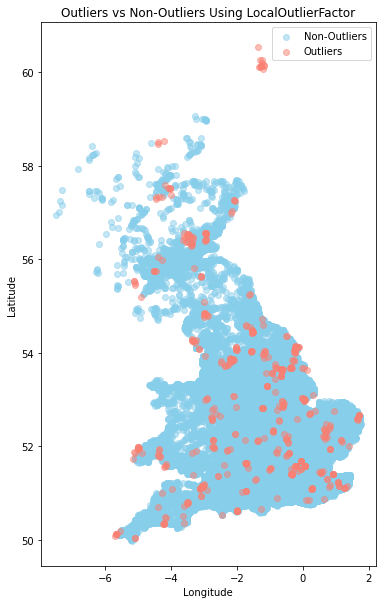

In [56]:
# Plotting the outliers and non-outliers
plt.figure(figsize=(6, 10))
plt.scatter(non_outliers["longitude"], non_outliers["latitude"], c='skyblue', label='Non-Outliers', alpha=0.5)
plt.scatter(outliers["longitude"], outliers["latitude"], c='salmon', label='Outliers', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Outliers vs Non-Outliers Using LocalOutlierFactor")
plt.legend()
# Save the figure
plt.savefig('outliers_vs_non_outliers LocalOutlierFactor.png', bbox_inches='tight')
plt.show()


The map illustrates that while many data points identified as outliers by the Local Outlier Factor algorithm appear to align with the overall distribution, a cluster of outliers stands out in the upper right corner. These outliers merit closer examination for potential anomalies requiring additional investigation.

## **Outlier Detection using IsolationForest**

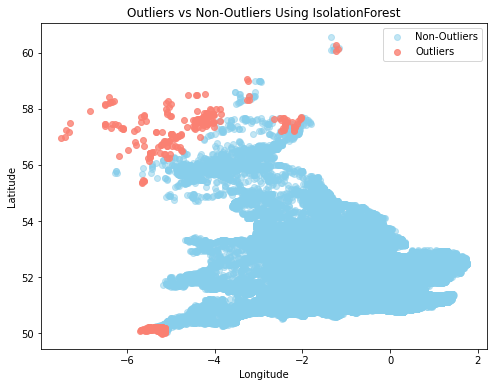

In [57]:
from sklearn.ensemble import IsolationForest
X = accident_df[["latitude", "longitude"]]

# Define the model
isolation_forest = IsolationForest(contamination=0.005, random_state=42)

# Fit the model and predict outliers
outlier_preds = isolation_forest.fit_predict(X)

# Filter outliers
outliers = accident_df[outlier_preds == -1]
non_outliers = accident_df[outlier_preds == 1]

# Plotting the outliers and non-outliers
plt.figure(figsize=(8, 6))
plt.scatter(non_outliers["longitude"], non_outliers["latitude"], c='skyblue', label='Non-Outliers', alpha=0.5)
plt.scatter(outliers["longitude"], outliers["latitude"], c='salmon', label='Outliers', alpha=0.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Outliers vs Non-Outliers Using IsolationForest")
plt.legend()
# Save the figure
plt.savefig('outliers_vs_non_outliers IsolationForest.png', bbox_inches='tight')

plt.show()



# **Accident Demography**

## **severity distribution of accidents**

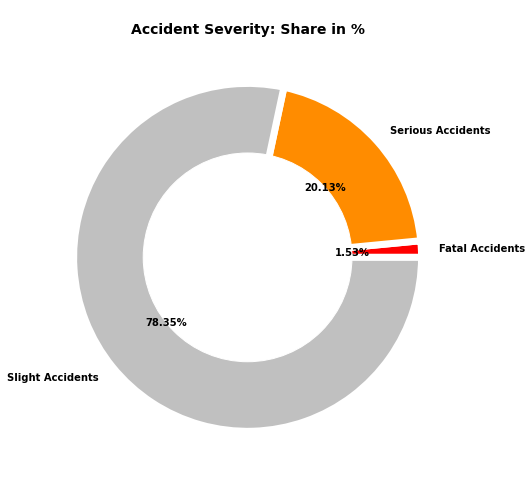

In [58]:
severity_counts = accident_df["accident_severity"].value_counts()
fatal = severity_counts[1]
serious = severity_counts[2]
slight = severity_counts[3]

names = ['Fatal Accidents', 'Serious Accidents', 'Slight Accidents']
size = [fatal, serious, slight]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
plt.pie(x=size, labels=names, colors=['red', 'darkorange', 'silver'],
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth': 7, 'edgecolor': 'white'})

# Create a circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0, 0), 0.6, color='white')
ax.add_artist(my_circle)
plt.title('\nAccident Severity: Share in %', fontsize=14, fontweight='bold')
# Save the figure
plt.savefig('accident_severity_pie_chart.png', bbox_inches='tight')
plt.show()


This visualization effectively communicates the severity distribution of accidents, highlighting the significant disparity between slight accidents and those resulting in fatal or serious outcomes. Such insights are crucial for understanding the overall safety landscape and can inform targeted interventions to mitigate severe accidents and improve road safety.

## **Main accident areas in the UK**

First we see using clustering then we applying Folium map to see main accident areas in the UK

In [59]:
accident_severe = accident_df[accident_df['accident_severity'] == 3]
accident_grave = accident_severe[accident_severe['number_of_casualties']>=3]
accident_grave.shape[0]/accident_df.shape[0]


0.03581179618197568

approximately 3.58% of the accidents in the accident dataset are severe and involve at least three casualties

In [60]:
def accident_importance(df):
    reformat_df = df[['accident_severity','number_of_vehicles', 'number_of_casualties']]
    reformat_df['number_of_vehicles'] = reformat_df['number_of_vehicles'].div(reformat_df['number_of_vehicles'].max())
    reformat_df['number_of_casualties'] = reformat_df['number_of_casualties'].div(reformat_df['number_of_casualties'].max()).mul(2)
    return reformat_df.sum(axis = 1).values

accident_grave['Importance'] = accident_importance(accident_grave)


In [61]:

accidents_red = accident_grave.drop(["accident_index","accident_year","accident_reference","date", "time", 'accident_severity','number_of_vehicles', 'number_of_casualties', 'day_of_week'], axis = 1).dropna()
print(accidents_red.shape)
accidents_red.head()


(3266, 28)


location_easting_osgr  location_northing_osgr  longitude   latitude  \
136               532575.0                192555.0  -0.086520  51.616219   
173               525791.0                174972.0  -0.190729  51.459756   
187               551891.0                177755.0   0.185884  51.478366   
279               518051.0                182704.0  -0.299502  51.530914   
285               531193.0                168108.0  -0.115555  51.396846   

     police_force  local_authority_district local_authority_ons_district  \
136             1                        32                    E09000010   
173             1                        10                    E09000032   
187             1                        18                    E09000004   
279             1                        27                    E09000009   
285             1                        20                    E09000008   

    local_authority_highway  first_road_class  first_road_number  ...  \
136               E09000010                 3                 10  ...   
173               E09000032                 3               3205  ...   
187               E09000004                 6                  0  ...   
279               E09000009                 3                 40  ...   
285               E09000008                 3                 23  ...   

     light_conditions  weather_conditions  road_surface_conditions  \
136                 4                   1                        1   
173                 1                   1                        1   
187                 1                   1                        1   
279                 4                   1                        1   
285                 4                   1                        2   

     special_conditions_at_site  carriageway_hazards  urban_or_rural_area  \
136                           0                    0                    1   
173                           0                    0                    1   
187                           0                    0                    1   
279                           0                    0                    1   
285                           0                    0                    1   

     did_police_officer_attend_scene_of_accident  trunk_road_flag  \
136                                            3                2   
173                                            1                2   
187                                            1                2   
279                                            1                2   
285                                            1                2   

     lsoa_of_accident_location  Importance  
136                  E01001560    3.570588  
173                  E01004509    3.652941  
187                  E01000429    3.552941  
279                  E01001277    4.105882  
285                  E01000995    3.552941  

[5 rows x 28 columns]

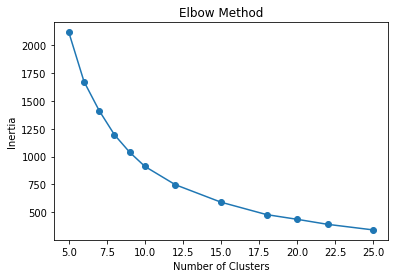

In [62]:
centres = [5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 22, 25]
inertie = []

for center in centres:
    kmeans = KMeans(center)
    kmeans.fit(accidents_red[['longitude', 'latitude']])
    inertie.append(kmeans.inertia_)

plt.plot(centres, inertie, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig("elbow2.png")
plt.show()


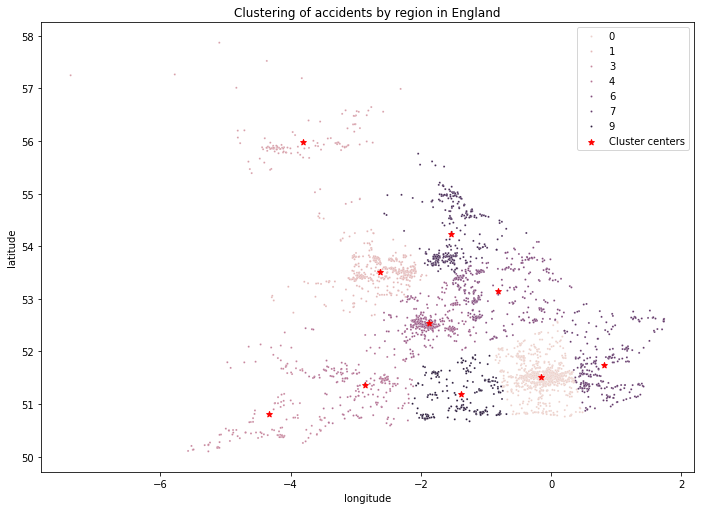

In [63]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(accidents_red[['longitude', 'latitude']])
accidents_red['Cluster'] = kmeans.labels_

# Set the size of the plot
plt.figure(figsize=(11.7, 8.27))

# Plot the scatterplot with clusters
sns.scatterplot(data=accidents_red, x='longitude', y='latitude', s=4, hue='Cluster')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Cluster centers', color='red', marker='*')
plt.legend()
plt.title('Clustering of accidents by region in England')
plt.savefig("Cluster by region of uk.png")
plt.show()


In [64]:
def score_silhouette_custom(df, centre):
    df_array = df.values
    silhouette_custom = 0
    for a in range(len(df_array)):
        silhouette_custom+=euclidean_distances([df_array[a], centre])[0][1]
    return round(len(df_array)/silhouette_custom,2)


In [65]:
from branca.colormap import linear
import branca.colormap as cm
from sklearn.metrics.pairwise import euclidean_distances

def color(num_cluster, df):
    df_treatement = df[df['Cluster'] == num_cluster]
    return df_treatement['Importance'].sum()/df_treatement.shape[0]

mini = 3.62
maxi = 3.66
colormap = cm.LinearColormap(colors=['lightgreen', 'red'], index=[mini,maxi],vmin=mini,vmax=maxi)

x_start = (accidents_red['latitude'].max() + accidents_red['latitude'].min()) / 2
y_start = (accidents_red['longitude'].max() + accidents_red['longitude'].min()) / 2
start_coord = (x_start, y_start)
m = folium.Map(location=start_coord, zoom_start=6)

tooltip = "Detail"
numeros_cluster = 0
for i in kmeans.cluster_centers_:
    decorticage = accidents_red[accidents_red['Cluster']==numeros_cluster][['longitude','latitude']]
    densite = score_silhouette_custom(decorticage, i)
    proportion = color(numeros_cluster, accidents_red)
    folium.Circle(
        location=[i[1],i[0]],
        radius=13000* densite,
        fill=True,
        color=colormap(proportion),
        fill_opacity=0.6,
        popup = "Importance " + str(round(proportion,2)) +"\n Densité " + str(densite) + "\n Cluster " + str(numeros_cluster),
    ).add_to(m)
    numeros_cluster+=1

m.add_child(colormap)

#save picture
img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('main accident areas in the UK.png')

#display
m


The images show the location of fatal road accidents in the UK. Each dot represents one accident, and the color of the dot indicates the severity of the accident. The darker the dot, the more severe the accident. The map shows that there are more accidents in the south of England than in the north. This may be because there are more people living in the south of England, or because the roads in the south are more dangerous

## **Driver and Casualty age piramids**

In [122]:
# Extracting relevant columns and merging the accident table with the casualty table
cursor.execute("""
SELECT c.accident_index, c.sex_of_casualty, c.age_of_casualty, c.age_band_of_casualty,c.casualty_severity, v.sex_of_driver, v.age_of_driver, v.age_band_of_driver
FROM Casualty c
JOIN Vehicle v ON c.accident_index = v.accident_index
WHERE c.accident_year = 2020;
""")
cv_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results

Ccv_df = pd.DataFrame(
    cv_data,
    columns=['accident_index', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty', 'casualty_severity','sex_of_driver', 'age_of_driver', 'age_band_of_driver'])

Ccv_df.head(5)

accident_index  sex_of_casualty  age_of_casualty  age_band_of_casualty  \
0  2020010219808                1               31                     6   
1  2020010220496                2                2                     1   
2  2020010220496                2                4                     1   
3  2020010228005                1               23                     5   
4  2020010228006                1               47                     8   

   casualty_severity  sex_of_driver  age_of_driver  age_band_of_driver  
0                  3              2             32                   6  
1                  3              1             45                   7  
2                  3              1             45                   7  
3                  3              3             -1                  -1  
4                  2              1             44                   7

In [123]:
columns=['sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty','casualty_severity','sex_of_driver', 'age_of_driver', 'age_band_of_driver']
for column in columns:
    unique_values = Ccv_df[column].unique()
    print(f"{column}: {unique_values}")


sex_of_casualty: [ 1  2 -1  9]
age_of_casualty: [31  2  4 23 47 32 33 25 41 50 62 37 -1 20 42 30 18 26 29 38 39 80 19 21
 48  7 79 45 27 44 51 83 52 43 22 59 60 77 12 54 10 40 56 24 88 11  9 35
  5  3 16 57 67  6 49 46 53 28 69 15 76 36 55 61 85 34  8 87 58 73 64 65
  0 78 71 14 13 17  1 68 91 66 92 74 75 63 70 84 86 94 72 90 81 82 89 93
 96 95 98 99 97]
age_band_of_casualty: [ 6  1  5  8  7  9 -1  4 11  2  3 10]
casualty_severity: [3 2 1]
sex_of_driver: [ 2  1  3 -1]
age_of_driver: [ 32  45  -1  44  20  25  41  19  26  62  37  40  33  51  30  18  29  24
  38  77  48  50  79  42  52  22  31  28  57  81  59  34  67  23  54  53
  27  39  56  43  88  35  46  16  49  21  80  66  47  55  60  36  58  70
  71  17  85  69  61  87  64  73  65  63  83  78  72  68  14  82  74  75
  11  76  15  86  90   9  10  91  84  13   8  89  93  94  92   6  12   5
   4   7  97  95   3  98 100  99  96]
age_band_of_driver: [ 6  7 -1  4  5  9  8 11 10  3  2  1]


In [124]:
Ccv_df = Ccv_df[(Ccv_df.sex_of_casualty != -1) & (Ccv_df.sex_of_casualty != 9)]
Ccv_df = Ccv_df[(Ccv_df.sex_of_driver != -1) & (Ccv_df.sex_of_driver != 3)]
Ccv_df = Ccv_df[(Ccv_df.age_band_of_casualty != -1)]
Ccv_df = Ccv_df[(Ccv_df.age_band_of_driver != -1)]


In [125]:
# Define age bands
age_bands = [0, 6, 11, 16, 21, 26, 36, 46, 56, 66, 76, float('inf')]
age_band_labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-35', '36-45', '46-55', '56-65', '66-75', 'over 75']

# Apply pd.cut() to create the new column 'age_band_age'
Ccv_df['age_band_casualty'] = pd.cut(Ccv_df['age_of_casualty'], bins=age_bands, labels=age_band_labels, right=False)

# Apply pd.cut() to create the new column 'age_band_driver'
Ccv_df['age_band_driver'] = pd.cut(Ccv_df['age_of_driver'], bins=age_bands, labels=age_band_labels, right=False)


# Display the DataFrame with the new columns and after filtering
Ccv_df.head(5)


accident_index  sex_of_casualty  age_of_casualty  age_band_of_casualty  \
0  2020010219808                1               31                     6   
1  2020010220496                2                2                     1   
2  2020010220496                2                4                     1   
4  2020010228006                1               47                     8   
5  2020010228011                2               32                     6   

   casualty_severity  sex_of_driver  age_of_driver  age_band_of_driver  \
0                  3              2             32                   6   
1                  3              1             45                   7   
2                  3              1             45                   7   
4                  2              1             44                   7   
5                  3              1             20                   4   

  age_band_casualty age_band_driver  
0             26-35           26-35  
1               0-5           36-45  
2               0-5           36-45  
4             46-55           36-45  
5             26-35           16-20

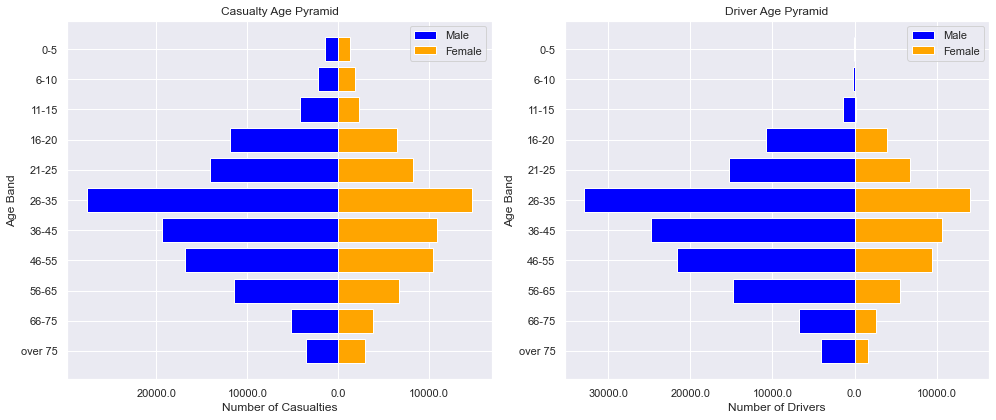

In [171]:
# Count casualties by age band and gender
casualty_female_counts = Ccv_df[Ccv_df['sex_of_casualty'] == 2]['age_band_casualty'].value_counts().sort_index()
casualty_male_counts = Ccv_df[Ccv_df['sex_of_casualty'] == 1]['age_band_casualty'].value_counts().sort_index()

# Count drivers by age band and gender
driver_female_counts = Ccv_df[Ccv_df['sex_of_driver'] == 2]['age_band_driver'].value_counts().sort_index()
driver_male_counts = Ccv_df[Ccv_df['sex_of_driver'] == 1]['age_band_driver'].value_counts().sort_index()

# Define the age bands in reverse order
age_bands = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-35', '36-45', '46-55', '56-65', '66-75', 'over 75']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the casualty pyramid
axs[0].barh(age_bands[::-1], -casualty_male_counts[::-1], color='blue', label='Male')
axs[0].barh(age_bands[::-1], casualty_female_counts[::-1], color='orange', label='Female')
axs[0].set_xlabel('Number of Casualties')
axs[0].set_ylabel('Age Band')
axs[0].set_title('Casualty Age Pyramid')
axs[0].legend()

# Plot the driver pyramid
axs[1].barh(age_bands[::-1], -driver_male_counts[::-1], color='blue', label='Male')
axs[1].barh(age_bands[::-1], driver_female_counts[::-1], color='orange', label='Female')
axs[1].set_xlabel('Number of Drivers')
axs[1].set_ylabel('Age Band')
axs[1].set_title('Driver Age Pyramid')
axs[1].legend()

# Set x-axis ticks to positive values
axs[0].set_xticklabels([abs(label) for label in axs[0].get_xticks()])
axs[1].set_xticklabels([abs(label) for label in axs[1].get_xticks()])

plt.tight_layout()
plt.savefig("Age Demography")
plt.show()


#### **Time series**

In [166]:
# Extracting relevant columns and merging the accident table with the casualty table
cursor.execute("""
SELECT a.accident_index, a.date, a.number_of_casualties,c.casualty_class
FROM Accident a
JOIN Casualty c ON a.accident_index = c.accident_index
WHERE a.accident_year = 2020;
""")
ac_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results
columns = ['accident_index', 'date', 'number_of_casualties', 'casualty_class']
accidentCasualty_df = pd.DataFrame(
    ac_data,
    columns=columns)

accidentCasualty_df.head(5)

accident_index        date  number_of_casualties  casualty_class
0  2020010219808  04/02/2020                     1               3
1  2020010220496  27/04/2020                     2               3
2  2020010220496  27/04/2020                     2               3
3  2020010228005  01/01/2020                     1               3
4  2020010228006  01/01/2020                     1               3

In [167]:
columns=['number_of_casualties']
for column in columns:
    unique_values = accidentCasualty_df[column].unique()
    print(f"{column}: {unique_values}")


number_of_casualties: [ 1  2  4  3  6  5  9 11  7  8 10 17 41 13 12 19]


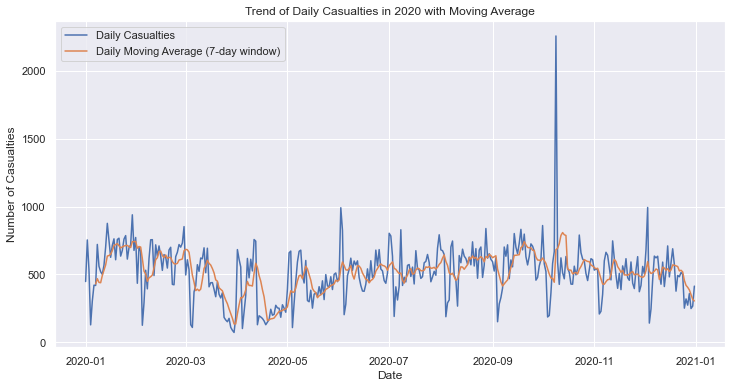

In [172]:
# Convert 'date' column to datetime format
accidentCasualty_df['date'] = pd.to_datetime(accidentCasualty_df['date'])

# Sort DataFrame by 'date'
accidentCasualty_df.sort_values(by='date', inplace=True)

# Filter the data for the year 2020
accidentCasualty_df_2020 = accidentCasualty_df[(accidentCasualty_df['date'] >= '2020-01-01') & (accidentCasualty_df['date'] <= '2020-12-31')]

# Group the data by date and count the number of casualties for each date
daily_casualties = accidentCasualty_df_2020.resample('D', on='date')['number_of_casualties'].sum()

# Calculate moving average for daily casualties
daily_moving_avg = daily_casualties.rolling(window=7).mean()

# Plot the daily casualties and their moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_casualties.index, daily_casualties, label='Daily Casualties')
plt.plot(daily_casualties.index, daily_moving_avg, label='Daily Moving Average (7-day window)')

# Extract month names from the index
plt.xlabel("Date")
plt.ylabel('Number of Casualties')
plt.title('Trend of Daily Casualties in 2020 with Moving Average')
plt.legend()
plt.grid(True)
plt.savefig("Daily casualties in 2020")
plt.show()


## **7. Classification Model: Accurately predicting fatal injuries sustained in road traffic accidents**

After a meticulous selection process, we've identified a comprehensive set of thirty-one (31) relevant features sourced from the accident, vehicle, and casualty tables. The criteria guiding this selection were tailored to prioritize features anticipated to have a significant impact on predicting accident severity.

In [66]:
cursor.execute("""
SELECT A.longitude, A.latitude, A.speed_limit, A.road_surface_conditions, A.weather_conditions, 
V.towing_and_articulation, V.hit_object_in_carriageway, A.light_conditions, V.vehicle_manoeuvre, 
A.accident_severity, A.time, A.day_of_week, A.road_type, A.junction_detail, A.special_conditions_at_site, 
A.junction_control, A.police_force, A.urban_or_rural_area, A.did_police_officer_attend_scene_of_accident, 
V.sex_of_driver, V.age_of_driver, V.driver_imd_decile, V.engine_capacity_cc, 
V.journey_purpose_of_driver, C.casualty_class, C.casualty_severity, C.pedestrian_location, C.pedestrian_movement, 
C.car_passenger, C.bus_or_coach_passenger, C.pedestrian_road_maintenance_worker
FROM Accident A
JOIN Vehicle V ON A.accident_index = V.accident_index
JOIN Casualty C ON A.accident_index = C.accident_index
WHERE A.accident_year = 2020;
""")
accidents_data = cursor.fetchall()

# Creating a pandas DataFrame to store the results
columns = ["longitude", "latitude", "speed_limit", "road_surface_conditions", "weather_conditions", 
           "towing_and_articulation", "hit_object_in_carriageway", "light_conditions", "vehicle_manoeuvre", 
           "accident_severity", "time", "day_of_week", "road_type", "junction_detail", "special_conditions_at_site", 
           "junction_control", "police_force", "urban_or_rural_area", "did_police_officer_attend_scene_of_accident", 
           "sex_of_driver", "age_of_driver", "driver_imd_decile", "engine_capacity_cc", 
           "journey_purpose_of_driver", "casualty_class", "casualty_severity", "pedestrian_location", "pedestrian_movement", 
           "car_passenger", "bus_or_coach_passenger", "pedestrian_road_maintenance_worker"]
df = pd.DataFrame(accidents_data, columns=columns)

In [67]:
# Displaying the dataframe
df.head(5)

longitude   latitude  speed_limit  road_surface_conditions  \
0  -0.254001  51.462262           20                        9   
1  -0.139253  51.470327           20                        1   
2  -0.139253  51.470327           20                        1   
3  -0.178719  51.529614           30                        2   
4  -0.001683  51.541210           30                        1   

   weather_conditions  towing_and_articulation  hit_object_in_carriageway  \
0                   9                        9                          0   
1                   1                        0                          0   
2                   1                        0                          0   
3                   1                        0                          0   
4                   1                        0                          0   

   light_conditions  vehicle_manoeuvre  accident_severity  ...  \
0                 1                  5                  3  ...   
1                 1                  4                  3  ...   
2                 1                  4                  3  ...   
3                 4                 18                  3  ...   
4                 4                 18                  2  ...   

  driver_imd_decile  engine_capacity_cc  journey_purpose_of_driver  \
0                 4                1968                          6   
1                 7                1395                          2   
2                 7                1395                          2   
3                -1                  -1                          6   
4                 2                1798                          1   

   casualty_class  casualty_severity  pedestrian_location  \
0               3                  3                    9   
1               3                  3                    1   
2               3                  3                    1   
3               3                  3                    5   
4               3                  2                    4   

   pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                    5              0                       0   
1                    1              0                       0   
2                    1              0                       0   
3                    9              0                       0   
4                    1              0                       0   

   pedestrian_road_maintenance_worker  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0  

[5 rows x 31 columns]

## **Basic EDA**

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 31 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   longitude                                    220401 non-null  float64
 1   latitude                                     220401 non-null  float64
 2   speed_limit                                  220435 non-null  int64  
 3   road_surface_conditions                      220435 non-null  int64  
 4   weather_conditions                           220435 non-null  int64  
 5   towing_and_articulation                      220435 non-null  int64  
 6   hit_object_in_carriageway                    220435 non-null  int64  
 7   light_conditions                             220435 non-null  int64  
 8   vehicle_manoeuvre                            220435 non-null  int64  
 9   accident_severity                            220435 non-nul

In [69]:
df.describe().T

count         mean  \
longitude                                    220401.0    -1.204230   
latitude                                     220401.0    52.364893   
speed_limit                                  220435.0    37.864432   
road_surface_conditions                      220435.0     1.378697   
weather_conditions                           220435.0     1.660208   
towing_and_articulation                      220435.0     0.188908   
hit_object_in_carriageway                    220435.0     6.629814   
light_conditions                             220435.0     2.047252   
vehicle_manoeuvre                            220435.0    18.525992   
accident_severity                            220435.0     2.758251   
day_of_week                                  220435.0     4.122884   
road_type                                    220435.0     5.209599   
junction_detail                              220435.0     3.670243   
special_conditions_at_site                   220435.0     0.213791   
junction_control                             220435.0     1.692109   
police_force                                 220435.0    27.989779   
urban_or_rural_area                          220435.0     1.357520   
did_police_officer_attend_scene_of_accident  220435.0     1.365019   
sex_of_driver                                220435.0     1.463016   
age_of_driver                                220435.0    35.156604   
driver_imd_decile                            220435.0     3.998526   
engine_capacity_cc                           220435.0  1407.144061   
journey_purpose_of_driver                    220435.0     4.714832   
casualty_class                               220435.0     1.340304   
casualty_severity                            220435.0     2.816418   
pedestrian_location                          220435.0     0.406079   
pedestrian_movement                          220435.0     0.331390   
car_passenger                                220435.0     0.235657   
bus_or_coach_passenger                       220435.0     0.031265   
pedestrian_road_maintenance_worker           220435.0     0.007277   

                                                     std        min  \
longitude                                       1.367863  -7.497375   
latitude                                        1.319584  49.970479   
speed_limit                                    14.616660  -1.000000   
road_surface_conditions                         0.856279  -1.000000   
weather_conditions                              1.770235  -1.000000   
towing_and_articulation                         1.234295  -1.000000   
hit_object_in_carriageway                      24.051623  -1.000000   
light_conditions                                1.731065  -1.000000   
vehicle_manoeuvre                              21.893068  -1.000000   
accident_severity                               0.470845   1.000000   
day_of_week                                     1.944851   1.000000   
road_type                                       1.665439   1.000000   
junction_detail                                11.544248  -1.000000   
special_conditions_at_site                      1.208083  -1.000000   
junction_control                                2.479581  -1.000000   
police_force                                   24.182384   1.000000   
urban_or_rural_area                             0.479593   1.000000   
did_police_officer_attend_scene_of_accident     0.634128  -1.000000   
sex_of_driver                                   0.672185  -1.000000   
age_of_driver                                  20.428323  -1.000000   
driver_imd_decile                               3.420620  -1.000000   
engine_capacity_cc                           1542.884192  -1.000000   
journey_purpose_of_driver                       1.907780  -1.000000   
casualty_class                                  0.608077   1.000000   
casualty_severity                               0.416149   1.000000   
pedestrian_location            

## **Feature Enginnering**

In [70]:
# Extracting the hour feature from the time feature
df['hour'] = pd.to_datetime(df['time'], format="%H:%M").dt.hour

In [71]:
# Dropping the time feature
df = df.drop("time", axis=1)

The time feature was dropped from the dataframe since it will not be used to build the classification model

## **Data cleaning**

In [72]:
#Check duplicated value
df.duplicated().sum()

22258

Before constructing the classification model, we need to address the presence of duplicate records in the combined dataframe obtained from table joins. A total of 22,258 duplicate entries have been identified, and we will proceed to remove them to ensure the integrity of the dataset.

In [73]:
# Dropping the duplicate rows
df = df.drop_duplicates()

In [74]:
# Confirming if the rows have been dropped
df.duplicated().sum()

0

In [75]:
##Checking missing values
df.isnull().sum()

longitude                                      29
latitude                                       29
speed_limit                                     0
road_surface_conditions                         0
weather_conditions                              0
towing_and_articulation                         0
hit_object_in_carriageway                       0
light_conditions                                0
vehicle_manoeuvre                               0
accident_severity                               0
day_of_week                                     0
road_type                                       0
junction_detail                                 0
special_conditions_at_site                      0
junction_control                                0
police_force                                    0
urban_or_rural_area                             0
did_police_officer_attend_scene_of_accident     0
sex_of_driver                                   0
age_of_driver                                   0


In the dataframe resulting from the table joins, we have detected 29 instances of missing values in the longitude and latitude features. Therefore, the following steps will focus on filling these missing values.

In [76]:
# Inspecting the rows with the missing values
null_rows = df[df.isnull().any(axis=1)]
null_rows[["longitude", "latitude", "police_force"]]

longitude  latitude  police_force
57197         NaN       NaN             5
57198         NaN       NaN             5
67235         NaN       NaN             7
67236         NaN       NaN             7
74986         NaN       NaN            12
74988         NaN       NaN            12
77129         NaN       NaN            13
77130         NaN       NaN            13
196628        NaN       NaN            52
196630        NaN       NaN            52
196632        NaN       NaN            52
209338        NaN       NaN            62
209339        NaN       NaN            62
209766        NaN       NaN            63
209767        NaN       NaN            63
209784        NaN       NaN            63
209785        NaN       NaN            63
209828        NaN       NaN            63
209829        NaN       NaN            63
209911        NaN       NaN            63
210122        NaN       NaN            63
210123        NaN       NaN            63
210652        NaN       NaN            63
210653        NaN       NaN            63
210654        NaN       NaN            63
210655        NaN       NaN            63
210676        NaN       NaN            63
210677        NaN       NaN            63
211315        NaN       NaN            63

The outcome indicates that there are 16 accidents with missing longitude and latitude coordinates, all associated with a police force code of 63. We can reasonably assume that these missing coordinates can be replaced with the average coordinates from accidents attributed to police force code 63. This approach will be applied consistently to address other instances of missing coordinates by using the average coordinates specific to their respective accidents.

In [77]:
def calculate_and_fill_mean_longitude_latitude(dataframe, police_code):
    accident_police_df = dataframe[dataframe["police_force"] == police_code]
    longitude_mean = round(accident_police_df["longitude"].mean(), 6)
    latitude_mean = round(accident_police_df["latitude"].mean(), 6)
    dataframe["longitude"].fillna(longitude_mean, inplace=True)
    dataframe["latitude"].fillna(latitude_mean, inplace=True)

    return dataframe

# List of police codes
police_codes = [63, 62, 52, 13, 12, 7, 5]

# Fill missing values in longitude and latitude for each police code
for code in police_codes:
    df = calculate_and_fill_mean_longitude_latitude(df, code)


In [78]:
df.isnull().sum()

longitude                                      0
latitude                                       0
speed_limit                                    0
road_surface_conditions                        0
weather_conditions                             0
towing_and_articulation                        0
hit_object_in_carriageway                      0
light_conditions                               0
vehicle_manoeuvre                              0
accident_severity                              0
day_of_week                                    0
road_type                                      0
junction_detail                                0
special_conditions_at_site                     0
junction_control                               0
police_force                                   0
urban_or_rural_area                            0
did_police_officer_attend_scene_of_accident    0
sex_of_driver                                  0
age_of_driver                                  0
driver_imd_decile   

In [79]:
# List of numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

data = {
    'Column': [],
    'Percentage of Negative Values': []
}


for column in numeric_columns:
    negative_count = (df[column] < 0).sum()
    percentage = (negative_count / len(df)) * 100
    data['Column'].append(column)
    data['Percentage of Negative Values'].append(percentage)
negative_percentage_df = pd.DataFrame(data)
negative_percentage_df = negative_percentage_df.set_index('Column')

print(negative_percentage_df)


                                             Percentage of Negative Values
Column                                                                    
longitude                                                        84.225717
latitude                                                          0.000000
speed_limit                                                       0.007064
road_surface_conditions                                           0.320421
weather_conditions                                                0.000505
towing_and_articulation                                           0.386523
hit_object_in_carriageway                                         0.364321
light_conditions                                                  0.000505
vehicle_manoeuvre                                                 0.391569
accident_severity                                                 0.000000
day_of_week                                                       0.000000
road_type                

In [80]:
# Filtering the DataFrame to include only columns with negative percentage greater than 0
filtered_negative_percentage_df = negative_percentage_df[negative_percentage_df['Percentage of Negative Values'] > 0]
print(filtered_negative_percentage_df)


                                             Percentage of Negative Values
Column                                                                    
longitude                                                        84.225717
speed_limit                                                       0.007064
road_surface_conditions                                           0.320421
weather_conditions                                                0.000505
towing_and_articulation                                           0.386523
hit_object_in_carriageway                                         0.364321
light_conditions                                                  0.000505
vehicle_manoeuvre                                                 0.391569
junction_detail                                                   0.002018
special_conditions_at_site                                        0.229088
junction_control                                                 41.829778
did_police_officer_attend

The table presents the percentage of negative values in numeric columns of the dataset. Most columns exhibit a low percentage of negative values, with some exceptions. Notably, longitude shows a high percentage of negatives (around 84%), while other features like age of driver and engine capacity also have relatively high percentages. The data may require further investigation or preprocessing to handle these negative values appropriately.

In [81]:
# Features to fill (excluding age_of_vehicle and age_of_driver)
features_to_fill = ["longitude", "latitude", "speed_limit", "road_surface_conditions", "weather_conditions",
                    "towing_and_articulation", "hit_object_in_carriageway", "light_conditions", "vehicle_manoeuvre",
                    "accident_severity", "day_of_week", "road_type", "junction_detail", "special_conditions_at_site",
                    "junction_control", "police_force", "urban_or_rural_area", "did_police_officer_attend_scene_of_accident",
                    "sex_of_driver", "driver_imd_decile", "engine_capacity_cc",
                    "journey_purpose_of_driver", "casualty_class", "casualty_severity", "pedestrian_location", "pedestrian_movement",
                    "car_passenger", "bus_or_coach_passenger", "pedestrian_road_maintenance_worker"]

# Filling missing values with mode for each feature (excluding age_of_vehicle and age_of_driver)
for feature in features_to_fill:
    mode_value = df[feature].mode()[0]
    df[feature].replace(-1, mode_value, inplace=True)

# Filling age_of_driver with median
age_of_driver_median = df["age_of_driver"].median()
df["age_of_driver"].replace(-1, age_of_driver_median, inplace=True)

# Displaying the modified dataframe
df.head(5)


longitude   latitude  speed_limit  road_surface_conditions  \
0  -0.254001  51.462262           20                        9   
1  -0.139253  51.470327           20                        1   
3  -0.178719  51.529614           30                        2   
4  -0.001683  51.541210           30                        1   
5  -0.137592  51.515704           30                        1   

   weather_conditions  towing_and_articulation  hit_object_in_carriageway  \
0                   9                        9                          0   
1                   1                        0                          0   
3                   1                        0                          0   
4                   1                        0                          0   
5                   1                        0                          0   

   light_conditions  vehicle_manoeuvre  accident_severity  ...  \
0                 1                  5                  3  ...   
1                 1                  4                  3  ...   
3                 4                 18                  3  ...   
4                 4                 18                  2  ...   
5                 4                 18                  3  ...   

   engine_capacity_cc  journey_purpose_of_driver  casualty_class  \
0                1968                          6               3   
1                1395                          2               3   
3                  -1                          6               3   
4                1798                          1               3   
5                2993                          6               3   

   casualty_severity  pedestrian_location  pedestrian_movement  car_passenger  \
0                  3                    9                    5              0   
1                  3                    1                    1              0   
3                  3                    5                    9              0   
4                  2                    4                    1              0   
5                  3                    6                    9              0   

   bus_or_coach_passenger  pedestrian_road_maintenance_worker  hour  
0                       0                                   0     9  
1                       0                                   0    13  
3                       0                                   0     1  
4                       0                                   0     1  
5                       0                                   0     2  

[5 rows x 31 columns]

For most features, the missing values (-1) are replaced with the mode of each feature. This approach is chosen because it is effective in handling categorical or discrete data where the mode represents the most frequent value.
However, for the "age_of_vehicle" and "age_of_driver" features, which likely represent continuous numerical data, a different approach is taken. Here, the missing values are imputed with the median values of their respective features. This method is selected to preserve the original data distribution and to ensure robustness to outliers, which is crucial for numerical data.

## **Correlation Analysis**

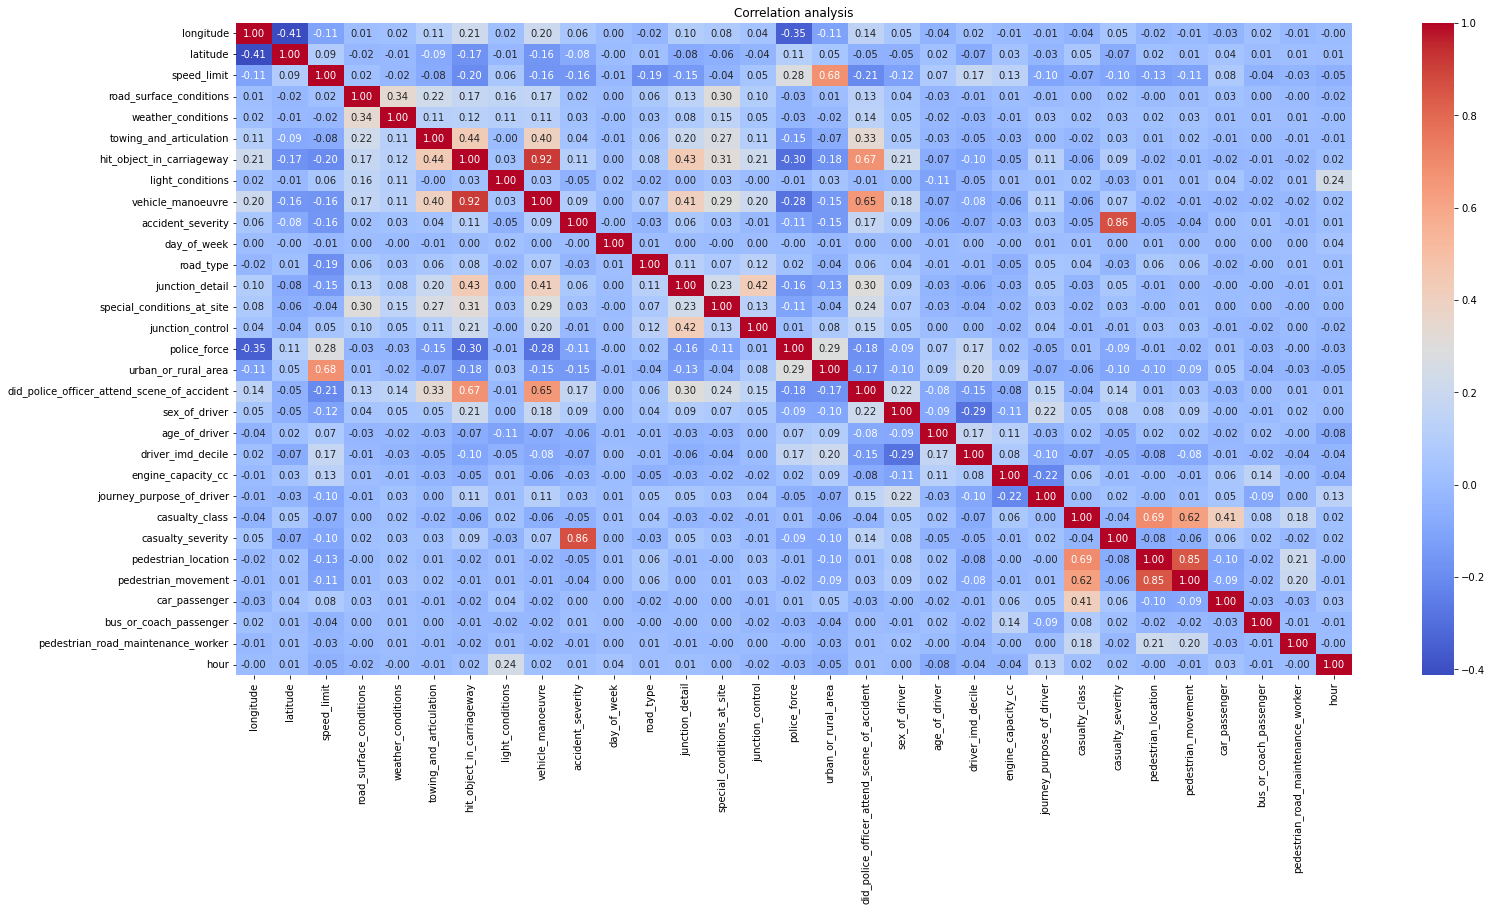

In [82]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation analysis")
plt.savefig("Correlation analysis.png")
plt.show()

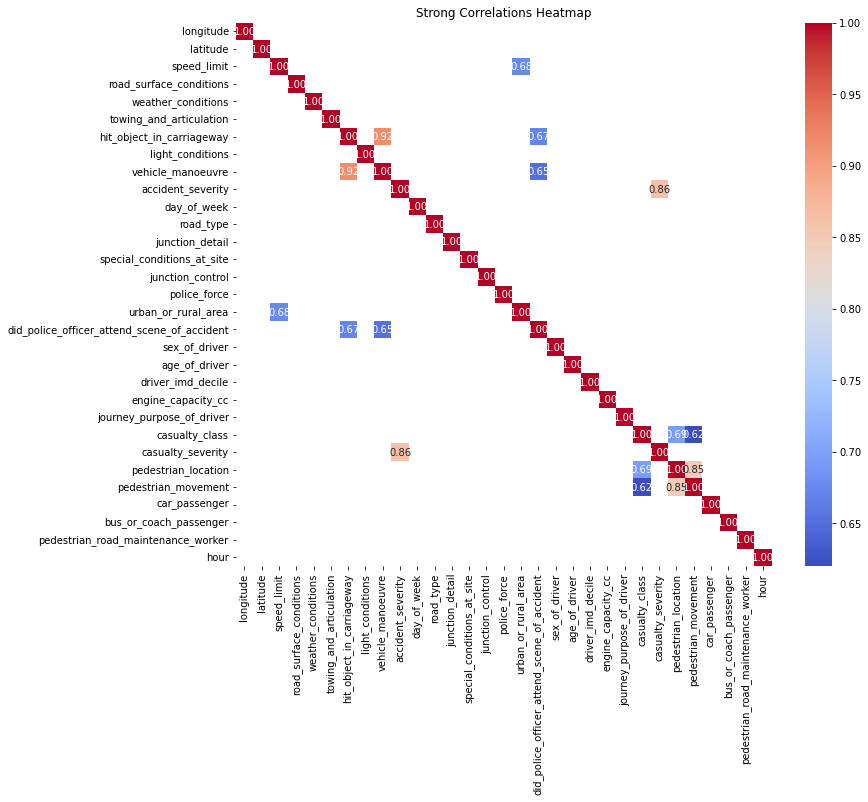

In [83]:
corr = df.corr()

# Filter out correlations below a certain threshold
strong_corr = corr[corr.abs() > 0.5]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Strong Correlations Heatmap')
plt.savefig("Strong correlation heatmap.png")
plt.show()


## **Data Preprocessing**

#### **X and y split**

In [84]:

# Preparing data for modeling
X = df.drop(['accident_severity', 'casualty_severity'], axis=1)
y = df['accident_severity']

#### **Imbalance handeling using SMOTE**

In [85]:
# Instantiating the SMOTE algorithm
smote = SMOTE(random_state=42)

# Applying SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Printing the class distribution before and after SMOTE
print("Class distribution before SMOTE:", y.value_counts())
print("Class distribution after SMOTE:", y_resampled.value_counts())

Class distribution before SMOTE: 3    152434
2     41817
1      3926
Name: accident_severity, dtype: int64
Class distribution after SMOTE: 3    152434
2    152434
1    152434
Name: accident_severity, dtype: int64


#### **Train test Split balanceing data**

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((365841, 29), (91461, 29), (365841,), (91461,))

#### **Normalization the features**

In [87]:
# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Model Building, traning, evaluation metrics**

#### **RandomForestClassifier**

Accuracy: 0.9247220126611343
Classification Report Random forest classifier:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99     30507
           2       0.90      0.88      0.89     30501
           3       0.89      0.90      0.89     30453

    accuracy                           0.92     91461
   macro avg       0.92      0.92      0.92     91461
weighted avg       0.92      0.92      0.92     91461



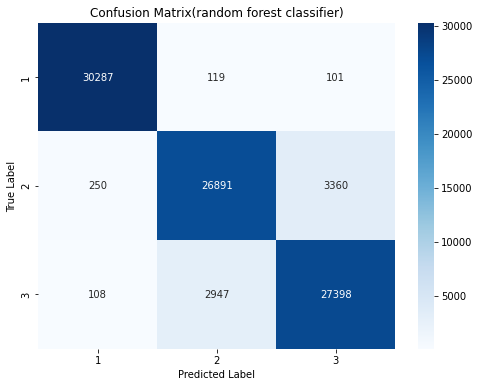

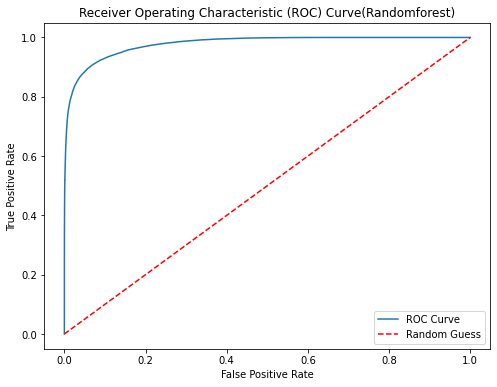

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


# Training a Random Forest Classifier
model_f = RandomForestClassifier(random_state=42)
model_f.fit(X_train_scaled, y_train)


# Making predictions on the train split set
y_pred_train = model_f.predict(X_train_scaled)

# Making predictions on the test split set
y_pred_test = model_f.predict(X_test_scaled)


# Model Performance Assessment for the test split set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_classification_rep = classification_report(y_test, y_pred_test)


# Print accuracy, and classification report
print("Accuracy:", test_accuracy)
print("Classification Report Random forest classifier:\n", test_classification_rep)



# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_f.classes_, yticklabels=model_f.classes_)
plt.title("Confusion Matrix(random forest classifier)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("Confusion matrix randomforest.png")
plt.show()

# ROC Curve
y_probs = model_f.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1], pos_label=model_f.classes_[1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve(Randomforest)')
plt.legend()
plt.savefig("Roc curve(Rf).png")
plt.show()


## **Feature Importance Using Randomforest classifier**

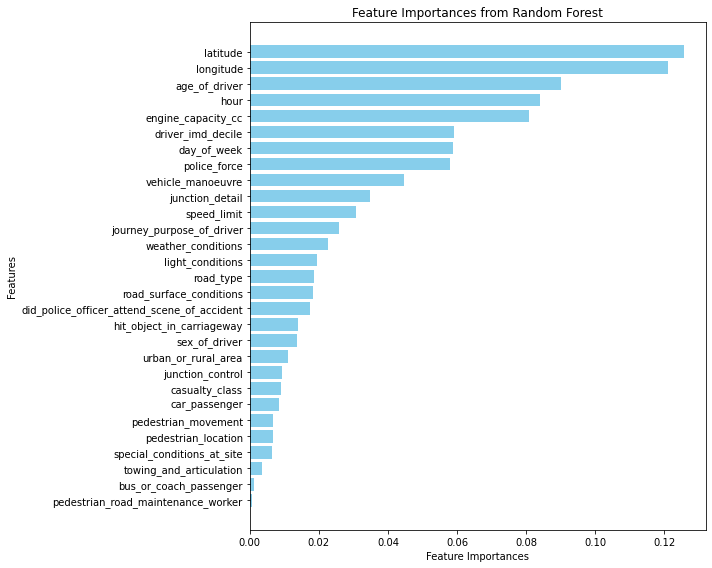

In [89]:
X = df.drop(['accident_severity', 'casualty_severity'], axis=1)
y = df['accident_severity']

# Feature importance using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_


# Sorting the feature_importance indices and values in descending order
sorted_indices = feature_importances.argsort()
sorted_values = feature_importances[sorted_indices]

# Creating a horizontal bar plot for feature importances
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_indices], sorted_values, color='skyblue')
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.savefig("Feature Importances from Random Forest.png")
plt.show()


## **RandomForestClassifier model improvement using Feature Importance**

In [ ]:
#After feature importance we selected 11 features

In [90]:
# Preparing data for modeling
X = df.drop(['accident_severity', 'casualty_severity', 'junction_control', 'casualty_class', 'car_passenger',
             'pedestrian_movement', 'pedestrian_location', 'special_conditions_at_site', 'towing_and_articulation',
            'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker'], axis=1)
y = df['accident_severity']

In [91]:
# Instantiating the SMOTE algorithm
smote2 = SMOTE(random_state=42)

# Applying SMOTE to the dataset
X_resampled, y_resampled = smote2.fit_resample(X, y)

# Printing the class distribution before and after SMOTE
print("Class distribution before SMOTE:", y.value_counts())
print("Class distribution after SMOTE:", y_resampled.value_counts())

Class distribution before SMOTE: 3    152434
2     41817
1      3926
Name: accident_severity, dtype: int64
Class distribution after SMOTE: 3    152434
2    152434
1    152434
Name: accident_severity, dtype: int64


In [92]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [93]:
# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.9248422825029248
Classification Report feature inportance Random forest classifier:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99     30507
           2       0.90      0.88      0.89     30501
           3       0.89      0.90      0.90     30453

    accuracy                           0.92     91461
   macro avg       0.92      0.92      0.92     91461
weighted avg       0.92      0.92      0.92     91461



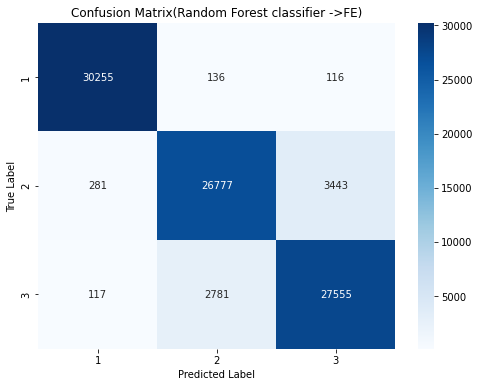

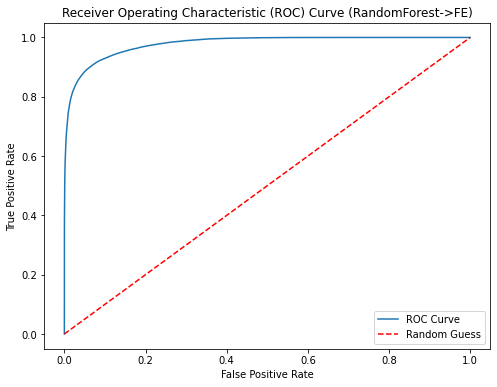

In [94]:
# Training a Random Forest Classifier
model_f1 = RandomForestClassifier(random_state=42)
model_f1.fit(X_train_scaled, y_train)


# Making predictions on the train split set
y_pred_train = model_f1.predict(X_train_scaled)

# Making predictions on the test split set
y_pred_test = model_f1.predict(X_test_scaled)


# Model Performance Assessment for the test split set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_classification_rep = classification_report(y_test, y_pred_test)



# Print accuracy, classification report
print("Accuracy:", test_accuracy)
print("Classification Report feature inportance Random forest classifier:\n", test_classification_rep)



# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_f1.classes_, yticklabels=model_f1.classes_)
plt.title("Confusion Matrix(Random Forest classifier ->FE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("Confusion matrix randomforest(balance).png")
plt.show()

# ROC Curve
y_probs = model_f1.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1], pos_label=model_f1.classes_[1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (RandomForest->FE)')
plt.legend()
plt.savefig("Roc curve(Rfbalance).png")
plt.show()


Without feature importance accuracy: 0.9247220126611343 and with feature importance accuracy is 0.9248422825029248. So we can say that feature importance analysis might have contributed to fine-tuning the model's performance, albeit the improvement is minimal.

## **GradientBoostingClassifier**

Accuracy: 0.6435311225549688
Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.75      0.70     30507
           2       0.57      0.47      0.52     30501
           3       0.69      0.71      0.70     30453

    accuracy                           0.64     91461
   macro avg       0.64      0.64      0.64     91461
weighted avg       0.64      0.64      0.64     91461



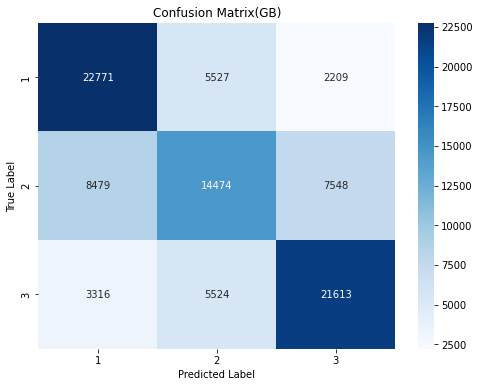

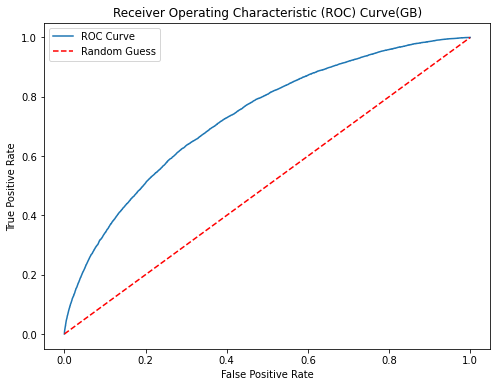

In [95]:
# Training a Gradient Boosting Classifier
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_scaled, y_train)


# Making predictions on the train split set
y_pred_train = model_gb.predict(X_train_scaled)

# Making predictions on the test split set
y_pred_test_gb = model_gb.predict(X_test_scaled)

# Model Performance Assessment for the test split set
test_accuracy = accuracy_score(y_test, y_pred_test_gb)
test_classification_rep = classification_report(y_test, y_pred_test_gb)

print("Accuracy:", test_accuracy)
print("Classification Report:\n", test_classification_rep)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_gb.classes_, yticklabels=model_gb.classes_)
plt.title("Confusion Matrix(GB)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("GradientBoosting ConfusionMatrix.png")
plt.show()

# ROC Curve
y_probs = model_gb.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1], pos_label=model_gb.classes_[1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve(GB)')
plt.legend()
plt.savefig("ROC curve for gradientBoosting.png")
plt.show()


## **DecisionTreeClassifier**

Accuracy: 0.8509419315336592
Classification Report :
               precision    recall  f1-score   support

           1       0.94      0.97      0.95     30507
           2       0.79      0.80      0.79     30501
           3       0.82      0.78      0.80     30453

    accuracy                           0.85     91461
   macro avg       0.85      0.85      0.85     91461
weighted avg       0.85      0.85      0.85     91461



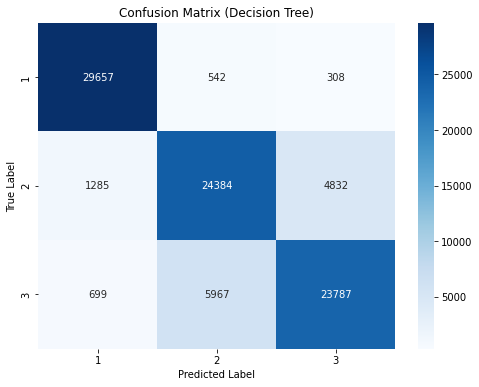

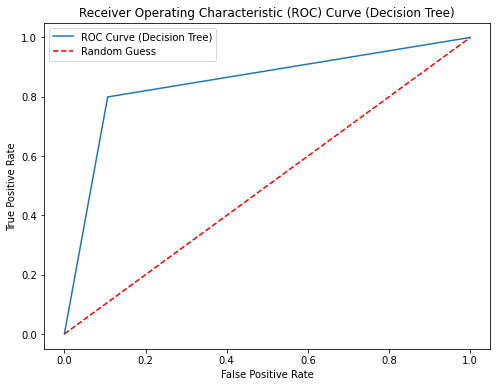

In [96]:
from sklearn.tree import DecisionTreeClassifier

# Training a Decision Tree Classifier
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_scaled, y_train)

# Making predictions on the train split set
y_pred_train_dt = model_dt.predict(X_train_scaled)

# Making predictions on the test split set
y_pred_test_dt = model_dt.predict(X_test_scaled)

# Model Performance Assessment for the test split set
test_accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
test_classification_rep_dt = classification_report(y_test, y_pred_test_dt)

print("Accuracy:", test_accuracy_dt)
print("Classification Report :\n", test_classification_rep_dt)

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_test_dt)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=model_dt.classes_, yticklabels=model_dt.classes_)
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("DecisionTree Cf.png")
plt.show()

# ROC Curve for Decision Tree
y_probs_dt = model_dt.predict_proba(X_test_scaled)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_probs_dt[:, 1], pos_label=model_dt.classes_[1])

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label='ROC Curve (Decision Tree)')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Decision Tree)')
plt.legend()
plt.savefig("DecisionTree Roc.png")
plt.show()


## **LogisticRegression**

Accuracy: 0.5585003444090924
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.68      0.62     30507
           2       0.46      0.42      0.44     30501
           3       0.64      0.58      0.61     30453

    accuracy                           0.56     91461
   macro avg       0.56      0.56      0.56     91461
weighted avg       0.56      0.56      0.56     91461



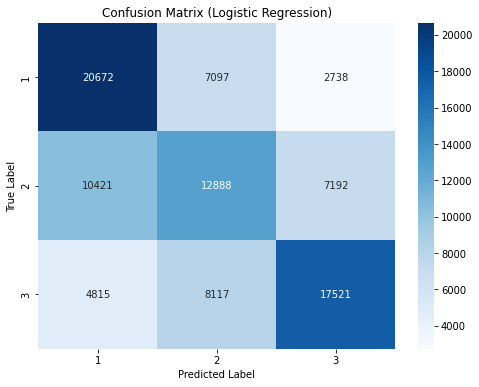

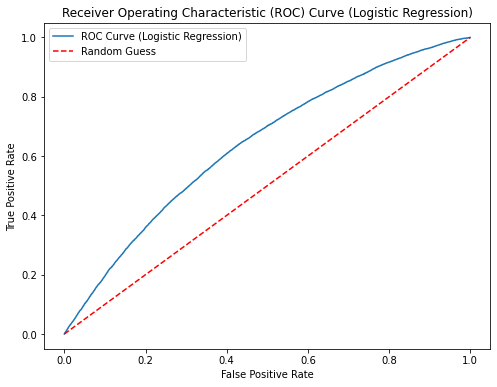

In [97]:
from sklearn.linear_model import LogisticRegression

# Training a Logistic Regression Model
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Making predictions on the train split set
y_pred_train_lr = model_lr.predict(X_train_scaled)

# Making predictions on the test split set
y_pred_test_lr = model_lr.predict(X_test_scaled)

# Model Performance Assessment for the test split set
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
test_classification_rep_lr = classification_report(y_test, y_pred_test_lr)

print("Accuracy:", test_accuracy_lr)
print("Classification Report:\n", test_classification_rep_lr)

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_test_lr)

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=model_lr.classes_, yticklabels=model_lr.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("Logistic CF.png")
plt.show()

# ROC Curve for Logistic Regression
y_probs_lr = model_lr.predict_proba(X_test_scaled)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_probs_lr[:, 1], pos_label=model_lr.classes_[1])

# Plot ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='ROC Curve (Logistic Regression)')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Logistic Regression)')
plt.legend()
plt.savefig("logistic ROC.png")
plt.show()


## **ALL Classifier Model using hyperparameter with pipeline**

In [98]:
# Preparing data for modeling
X = df.drop(['accident_severity', 'casualty_severity'], axis=1)
y = df['accident_severity']

In [99]:
# Instantiating the SMOTE algorithm
smote = SMOTE(random_state=42)

# Applying SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Printing the class distribution before and after SMOTE
print("Class distribution before SMOTE:", y.value_counts())
print("Class distribution after SMOTE:", y_resampled.value_counts())

Class distribution before SMOTE: 3    152434
2     41817
1      3926
Name: accident_severity, dtype: int64
Class distribution after SMOTE: 3    152434
2    152434
1    152434
Name: accident_severity, dtype: int64


In [100]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)


In [102]:
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression":LogisticRegression(solver='liblinear', penalty='l1'),
    "GradientBoostingClassifier":GradientBoostingClassifier(n_estimators=100,random_state=42)
}

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [104]:
accuracy_scores = []
precision_scores = []
recall_scores = []  
f1_scores = []

for name, clf in classifiers.items():
    current_accuracy, current_precision, current_recall,current_f1 = train_classifier(clf, X_train, y_train, X_test, y_test)

    print("\nFor ", name)
    print("Accuracy - ", current_accuracy)
    print("Precision - ", current_precision)
    print("Recall - ", current_recall)
    print("F1 Score - ", current_f1)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


For  Random Forest
Accuracy -  0.924295601403877
Precision -  0.9242113692973217
Recall -  0.924295601403877
F1 Score -  0.924218202671383

For  Decision Tree
Accuracy -  0.8458468636905347
Precision -  0.8446544217237233
Recall -  0.8458468636905347
F1 Score -  0.8448691275503024

For  Logistic Regression
Accuracy -  0.5695433026098555
Precision -  0.5648682117289843
Recall -  0.5695433026098555
F1 Score -  0.5642445391799197

For  GradientBoostingClassifier
Accuracy -  0.6543882091820558
Precision -  0.6489123321724996
Recall -  0.6543882091820558
F1 Score -  0.648752795319955


In [105]:
performance_df = pd.DataFrame({
    'Algorithm': classifiers.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1_Score': f1_scores
})

performance_df.sort_values('Accuracy', ascending=False, inplace=True)
performance_df.set_index("Algorithm", inplace=True)

performance_df


Accuracy  Precision    Recall  F1_Score
Algorithm                                                          
Random Forest               0.924296   0.924211  0.924296  0.924218
Decision Tree               0.845847   0.844654  0.845847  0.844869
GradientBoostingClassifier  0.654388   0.648912  0.654388  0.648753
Logistic Regression         0.569543   0.564868  0.569543  0.564245

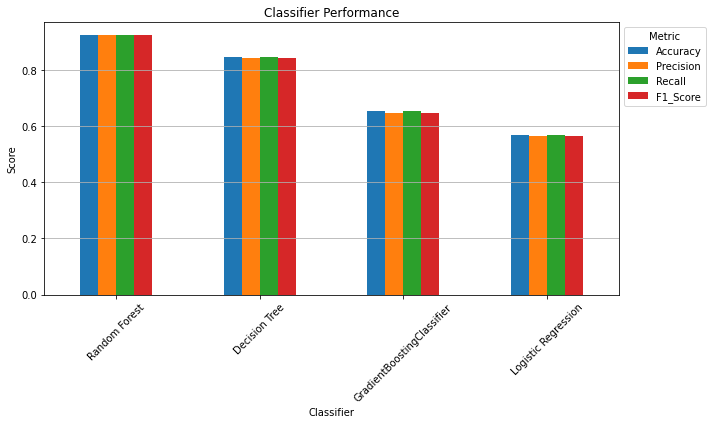

In [106]:
# Visualize the sorted DataFrame
performance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classifier Performance')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("Classification Performance.png")
plt.show()